## Step 1: Load Human-Human-GPT Data

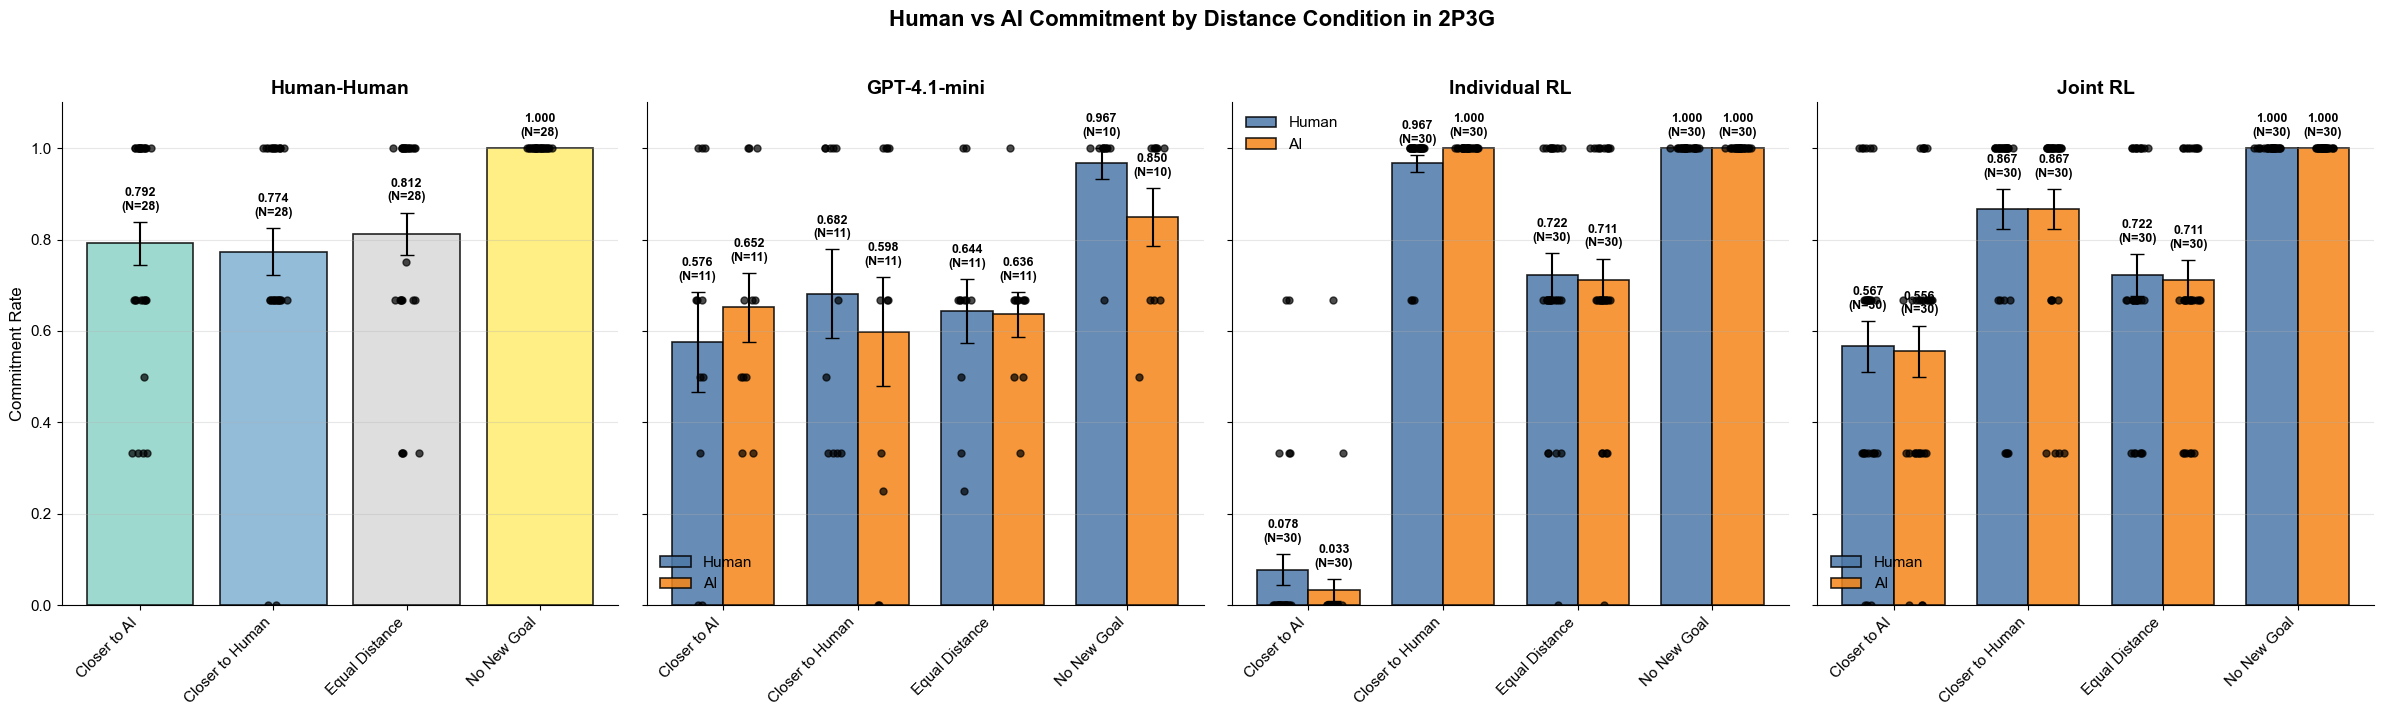

In [96]:
# Combined Human and AI Commitment by Distance Condition (2P3G)
# - Keeps original Human-Human panel (single series)
# - For three human-AI game types, uses grouped bars with hue = {Human, AI}

if 'merged_commitment_data' in locals() and not merged_commitment_data.empty and 'ai_commitment_data' in locals() and not ai_commitment_data.empty:
    # Ensure participant-level human commitment by distance is available
    if 'participant_distance_commitment' not in locals() or participant_distance_commitment.empty:
        participant_distance_commitment = merged_commitment_data.groupby([
            'participant_id', 'game_type', 'study', 'distanceCondition'
        ])['human_commitment'].mean().reset_index()
        participant_distance_commitment['commitment_rate'] = participant_distance_commitment['human_commitment']

    # Ensure participant-level AI commitment by distance
    if 'ai_participant_distance_commitment' not in locals() or ai_participant_distance_commitment.empty:
        ai_participant_distance_commitment = ai_commitment_data.groupby([
            'participant_id', 'game_type', 'distanceCondition'
        ])['ai_commitment'].mean().reset_index()
        ai_participant_distance_commitment['ai_commitment_rate'] = ai_participant_distance_commitment['ai_commitment']

    # Panels: Human-Human + 3 human-AI types
    panels = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    panel_labels = ['Human-Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
    available_panels = [p for p in panels if p in participant_distance_commitment['game_type'].values or p in ai_participant_distance_commitment['game_type'].values]

    # Distance order and labels
    distance_order = ['closer_to_AI', 'closer_to_human', 'equal_to_both', 'no_new_goal']
    label_map = {
        'closer_to_AI': 'Closer to AI',
        'closer_to_human': 'Closer to Human',
        'equal_to_both': 'Equal Distance',
        'no_new_goal': 'No New Goal'
    }

    # Colors
    distance_colors = plt.cm.Set3(np.linspace(0, 1, len(distance_order)))
    agent_colors = {'Human': '#4C78A8', 'AI': '#F58518'}

    fig, axes = plt.subplots(1, len(available_panels), figsize=(6 * len(available_panels), 7), sharey=True)
    if len(available_panels) == 1:
        axes = [axes]

    for i, game_type in enumerate(available_panels):
        ax = axes[i]
        title = panel_labels[panels.index(game_type)]

        # Determine which conditions exist for this panel
        conds_h = []
        if game_type in participant_distance_commitment['game_type'].values:
            conds_h = list(participant_distance_commitment[participant_distance_commitment['game_type'] == game_type]['distanceCondition'].dropna().unique())
        conds_ai = []
        if game_type in ai_participant_distance_commitment['game_type'].values:
            conds_ai = list(ai_participant_distance_commitment[ai_participant_distance_commitment['game_type'] == game_type]['distanceCondition'].dropna().unique())
        conds = [d for d in distance_order if d in set(conds_h) | set(conds_ai)]
        colors_for_conds = {d: distance_colors[distance_order.index(d)] for d in conds if d in distance_order}

        if game_type == 'human':
            # Single series (human only), distance-colored as in original
            means, ses, ns, labels, colors = [], [], [], [], []
            for j, d in enumerate(conds):
                data = participant_distance_commitment[(participant_distance_commitment['game_type'] == 'human') & (participant_distance_commitment['distanceCondition'] == d)]['commitment_rate']
                if len(data) > 0:
                    means.append(data.mean())
                    ses.append(data.std() / np.sqrt(len(data)))
                    ns.append(len(data))
                    labels.append(label_map.get(d, str(d)))
                    colors.append(colors_for_conds[d])
            bars = ax.bar(range(len(means)), means, yerr=ses, capsize=5, alpha=0.85, color=colors, edgecolor='black', linewidth=1.2)
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha='right')
            # Jittered dots
            for j, d in enumerate(conds):
                data = participant_distance_commitment[(participant_distance_commitment['game_type'] == 'human') & (participant_distance_commitment['distanceCondition'] == d)]['commitment_rate']
                if len(data) > 0:
                    x = np.random.normal(j, 0.04, size=len(data))
                    ax.scatter(x, data, color='black', alpha=0.7, s=25, zorder=3)
            for bar, mean_val, se_val, n in zip(bars, means, ses, ns):
                ax.text(bar.get_x() + bar.get_width()/2., mean_val + se_val + 0.02, f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            # Grouped bars: Human vs AI per distance condition
            width = 0.38
            xs = np.arange(len(conds))
            # Human
            h_means, h_ses, h_ns = [], [], []
            a_means, a_ses, a_ns = [], [], []
            for d in conds:
                hdata = participant_distance_commitment[(participant_distance_commitment['game_type'] == game_type) & (participant_distance_commitment['distanceCondition'] == d)]['commitment_rate']
                adata = ai_participant_distance_commitment[(ai_participant_distance_commitment['game_type'] == game_type) & (ai_participant_distance_commitment['distanceCondition'] == d)]['ai_commitment_rate']
                if len(hdata) > 0:
                    h_means.append(hdata.mean())
                    h_ses.append(hdata.std() / np.sqrt(len(hdata)))
                    h_ns.append(len(hdata))
                else:
                    h_means.append(np.nan)
                    h_ses.append(0)
                    h_ns.append(0)
                if len(adata) > 0:
                    a_means.append(adata.mean())
                    a_ses.append(adata.std() / np.sqrt(len(adata)))
                    a_ns.append(len(adata))
                else:
                    a_means.append(np.nan)
                    a_ses.append(0)
                    a_ns.append(0)
            bars_h = ax.bar(xs - width/2, h_means, width, yerr=h_ses, capsize=5, label='Human', color=agent_colors['Human'], alpha=0.85, edgecolor='black', linewidth=1.2)
            bars_a = ax.bar(xs + width/2, a_means, width, yerr=a_ses, capsize=5, label='AI', color=agent_colors['AI'], alpha=0.85, edgecolor='black', linewidth=1.2)
            ax.set_xticks(xs)
            ax.set_xticklabels([label_map.get(d, str(d)) for d in conds], rotation=45, ha='right')
            # Jittered dots (offset by series)
            for j, d in enumerate(conds):
                hdata = participant_distance_commitment[(participant_distance_commitment['game_type'] == game_type) & (participant_distance_commitment['distanceCondition'] == d)]['commitment_rate']
                adata = ai_participant_distance_commitment[(ai_participant_distance_commitment['game_type'] == game_type) & (ai_participant_distance_commitment['distanceCondition'] == d)]['ai_commitment_rate']
                if len(hdata) > 0:
                    xh = np.random.normal(j - width/2, 0.04, size=len(hdata))
                    ax.scatter(xh, hdata, color='black', alpha=0.7, s=25, zorder=3)
                if len(adata) > 0:
                    xa = np.random.normal(j + width/2, 0.04, size=len(adata))
                    ax.scatter(xa, adata, color='black', alpha=0.7, s=25, zorder=3)
            # Value labels
            for bar, mean_val, se_val, n in zip(bars_h, h_means, h_ses, h_ns):
                if not np.isnan(mean_val):
                    ax.text(bar.get_x() + bar.get_width()/2., mean_val + se_val + 0.02, f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontsize=9, fontweight='bold')
            for bar, mean_val, se_val, n in zip(bars_a, a_means, a_ses, a_ns):
                if not np.isnan(mean_val):
                    ax.text(bar.get_x() + bar.get_width()/2., mean_val + se_val + 0.02, f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontsize=9, fontweight='bold')
            ax.legend(frameon=False)

        ax.set_title(title, fontweight='bold')
        if i == 0:
            ax.set_ylabel('Commitment Rate')
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.suptitle('Human vs AI Commitment by Distance Condition in 2P3G', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('merged_human_ai_commitment_by_distance_combined_2p3g.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('Commitment datasets not ready. Please run human and AI commitment prep cells first.')


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
import ast
import glob
import os
from itertools import combinations
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Define consistent color scheme for all conditions
CONDITION_COLORS = {
    'human': '#2E86C1',        # Blue
    'gpt-4.1-mini': '#E74C3C', # Red
    'individual_rl': '#28B463', # Green
    'joint_rl': '#F39C12'      # Orange
}

print("Libraries loaded and styling configured!")

Libraries loaded and styling configured!


# Merged Collaboration Analysis: Human-Human-GPT vs Human-RL

This notebook merges collaboration success analysis from two studies:
1. Human-Human-GPT study (3 conditions: human, gpt-4.1-mini, mixed types)
2. Human-RL study (2 conditions: individual rl, joint rl)

Goal: Plot collaboration success across all four game types for comparison, plus comprehensive questionnaire analysis.

In [98]:
# Ensure game_type_order and labels are defined early for downstream cells
try:
    game_type_order
except NameError:
    game_type_order = ["human", "gpt-4.1-mini", "individual_rl", "joint_rl"]
try:
    game_type_labels
except NameError:
    _pretty = {
        'human': 'Human',
        'gpt-4.1-mini': 'GPT-4.1-mini',
        'individual_rl': 'Individual RL',
        'joint_rl': 'Joint RL',
    }
    game_type_labels = [_pretty.get(gt, gt) for gt in game_type_order]

# Define distance condition renaming function for all human-AI games
def rename_distance_condition_human_ai(row, study_type):
    """
    Rename distanceCondition values to be more intuitive for human-AI games.

    For Human-RL: player2 is always AI, so:
    - closer_to_player1 → closer_to_human
    - closer_to_player2 → closer_to_AI

    For Human-Human-GPT: rename based on humanPlayerIndex:
    - If human is player1 (index 0): closer_to_player1 → closer_to_human, closer_to_player2 → closer_to_AI
    - If human is player2 (index 1): closer_to_player1 → closer_to_AI, closer_to_player2 → closer_to_human
    """
    distance_condition = row.get('distanceCondition')

    if pd.isna(distance_condition) or distance_condition in ['no_new_goal', 'equal_to_both']:
        return distance_condition  # Keep these as-is

    if study_type == 'Human-RL':
        # In Human-RL, player1 is always human, player2 is always AI
        mapping = {
            'closer_to_player1': 'closer_to_human',
            'closer_to_player2': 'closer_to_AI',
            'farther_to_player1': 'farther_to_human',
            'equal_to_player1': 'equal_to_human'
        }
        return mapping.get(distance_condition, distance_condition)

    elif study_type == 'Human-Human-GPT':
        # In Human-Human-GPT, need to check humanPlayerIndex
        human_index = row.get('humanPlayerIndex', 0)  # Default to 0 if missing

        if human_index == 0:  # Human is player1
            mapping = {
                'closer_to_player1': 'closer_to_human',
                'closer_to_player2': 'closer_to_AI',
                'farther_to_player1': 'farther_to_human',
                'equal_to_player1': 'equal_to_human'
            }
        else:  # Human is player2 (index 1)
            mapping = {
                'closer_to_player1': 'closer_to_AI',
                'closer_to_player2': 'closer_to_human',
                'farther_to_player1': 'farther_to_AI',
                'equal_to_player1': 'equal_to_AI'
            }

        return mapping.get(distance_condition, distance_condition)

    return distance_condition  # Fallback for other studies

# Define commitment calculation function
def calculate_human_commitment_2p3g_merged(row, study_type):
    """Calculate commitment for human player in 2P3G based on study and player index"""
    shared_goal = row.get('firstDetectedSharedGoal')

    if pd.isna(shared_goal):
        return np.nan

    if study_type == 'Human-Human-GPT':
        # For human-human-gpt: use humanPlayerIndex to determine which player is human
        human_index = row.get('humanPlayerIndex')
        if pd.isna(human_index):
            human_index = 0  # Default to player 0 for human-human games

        # Get human player's final goal based on their index
        if human_index == 0:
            human_final_goal = row.get('player1FinalReachedGoal')
        else:  # human_index == 1
            human_final_goal = row.get('player2FinalReachedGoal')

    elif study_type == 'Human-RL':
        # For human-rl: human is always player 1 (index 0), so use player1FinalReachedGoal
        human_final_goal = row.get('player1FinalReachedGoal')

    else:
        return np.nan

    if pd.isna(human_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        human_final_goal = int(human_final_goal)
        return 1 if shared_goal == human_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

print("✅ Global variables and utility functions defined")

✅ Global variables and utility functions defined


## Step 2: Load and Process Human-RL Data

In [99]:
# Load human-human-gpt collaboration success data (participant-level)
hh_gpt_data = pd.read_csv('human-human-with-gpt-fallback/collaboration_success_by_gameType_participants.csv')

print("Human-Human-GPT Data:")
print(f"Shape: {hh_gpt_data.shape}")
print(f"Columns: {list(hh_gpt_data.columns)}")
print(f"Game types: {hh_gpt_data['game_type'].value_counts()}")

# Calculate summary statistics for human-human-gpt data
hh_gpt_summary = hh_gpt_data.groupby('game_type')['success_rate'].agg(['mean', 'std', 'count']).round(3)
hh_gpt_summary['se'] = hh_gpt_summary['std'] / np.sqrt(hh_gpt_summary['count'])
print("\nHuman-Human-GPT Summary:")
print(hh_gpt_summary)

Human-Human-GPT Data:
Shape: (50, 8)
Columns: ['participant_id', 'file_name', 'game_type', 'human_percentage', 'total_trials', 'successful_trials', 'success_rate', 'multiplayer_trials']
Game types: game_type
human           28
gpt-4.1-mini    11
mixed           11
Name: count, dtype: int64

Human-Human-GPT Summary:
               mean    std  count        se
game_type                                  
gpt-4.1-mini  0.693  0.278     11  0.083820
human         0.982  0.034     28  0.006425
mixed         0.859  0.155     11  0.046734


## Step 3: Merge Datasets and Prepare for Analysis

In [100]:
# Load human-RL data from original files
rl_data_dir = Path('human-RLs/data-original')
excel_files = [f for f in rl_data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

def load_and_process_rl_file(file_path):
    """Load Excel file and add metadata for RL data"""
    try:
        df = pd.read_excel(file_path)
        participant_id = file_path.name.split('_')[2]
        df = df.assign(participantID=participant_id)
        return df
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")
        return None

# Load all RL files
rl_data_frames = [load_and_process_rl_file(f) for f in excel_files if load_and_process_rl_file(f) is not None]
rl_combined_data = pd.concat(rl_data_frames, ignore_index=True)

# Focus on 2P3G experiments only for collaboration analysis
rl_filtered_data = rl_combined_data[rl_combined_data['experimentType'] == '2P3G'].copy()

# Rename distance conditions for Human-RL data
rl_filtered_data['study_type'] = 'Human-RL'
rl_filtered_data['distanceCondition_renamed'] = rl_filtered_data.apply(
    lambda row: rename_distance_condition_human_ai(row, 'Human-RL'), axis=1
)

print(f"Human-RL data loaded: {len(rl_filtered_data)} trials from {rl_filtered_data['participantID'].nunique()} participants")
print(f"RL Agent types: {rl_filtered_data['rlAgentType'].value_counts()}")

# Show distance condition renaming
print(f"\nDistance Condition Renaming for Human-RL:")
original_conditions = rl_filtered_data['distanceCondition'].value_counts()
renamed_conditions = rl_filtered_data['distanceCondition_renamed'].value_counts()
print("Original:")
print(original_conditions)
print("\nRenamed:")
print(renamed_conditions)

# Calculate participant-level success rates for human-RL data
rl_participant_success = rl_filtered_data.groupby(['participantID', 'rlAgentType'])['collaborationSucceeded'].mean().reset_index()
rl_participant_success['success_rate'] = rl_participant_success['collaborationSucceeded']
rl_participant_success['game_type'] = rl_participant_success['rlAgentType'].map({
    'individual': 'individual_rl',
    'joint': 'joint_rl'
})

print("\nHuman-RL participant-level data:")
print(f"Shape: {rl_participant_success.shape}")
print(f"Game types: {rl_participant_success['game_type'].value_counts()}")

# Calculate summary statistics for human-RL data
rl_summary = rl_participant_success.groupby('game_type')['success_rate'].agg(['mean', 'std', 'count']).round(3)
rl_summary['se'] = rl_summary['std'] / np.sqrt(rl_summary['count'])
print("\nHuman-RL Summary:")
print(rl_summary)

Human-RL data loaded: 720 trials from 60 participants
RL Agent types: rlAgentType
joint         360
individual    360
Name: count, dtype: int64

Distance Condition Renaming for Human-RL:
Original:
distanceCondition
equal_to_both        180
closer_to_player1    180
closer_to_player2    180
no_new_goal          180
Name: count, dtype: int64

Renamed:
distanceCondition_renamed
equal_to_both      180
closer_to_human    180
closer_to_AI       180
no_new_goal        180
Name: count, dtype: int64

Human-RL participant-level data:
Shape: (60, 5)
Game types: game_type
individual_rl    30
joint_rl         30
Name: count, dtype: int64

Human-RL Summary:
                mean    std  count        se
game_type                                   
individual_rl  0.978  0.043     30  0.007851
joint_rl       0.992  0.025     30  0.004564


## Step 4: Create Merged Collaboration Success Visualization

In [101]:
# Prepare human-human-gpt data for merging
hh_gpt_for_merge = hh_gpt_data[['participant_id', 'game_type', 'success_rate']].copy()
hh_gpt_for_merge['study'] = 'Human-Human-GPT'
hh_gpt_for_merge = hh_gpt_for_merge.rename(columns={'participant_id': 'participantID'})

# Prepare human-RL data for merging
rl_for_merge = rl_participant_success[['participantID', 'game_type', 'success_rate']].copy()
rl_for_merge['study'] = 'Human-RL'

# Combine both datasets
merged_data = pd.concat([hh_gpt_for_merge, rl_for_merge], ignore_index=True)

print("Merged Dataset:")
print(f"Total participants: {len(merged_data)}")
print(f"Studies: {merged_data['study'].value_counts()}")
print(f"Game types: {merged_data['game_type'].value_counts()}")

# Create overall summary statistics
overall_summary = merged_data.groupby(['study', 'game_type'])['success_rate'].agg(['mean', 'std', 'count']).round(3)
overall_summary['se'] = overall_summary['std'] / np.sqrt(overall_summary['count'])
print("\nOverall Summary by Study and Game Type:")
print(overall_summary)

# Create combined summary for visualization (ignoring study division)
combined_summary = merged_data.groupby('game_type')['success_rate'].agg(['mean', 'std', 'count']).round(3)
combined_summary['se'] = combined_summary['std'] / np.sqrt(combined_summary['count'])
combined_summary = combined_summary.reset_index()
print("\nCombined Summary Across All Game Types:")
print(combined_summary)

Merged Dataset:
Total participants: 110
Studies: study
Human-RL           60
Human-Human-GPT    50
Name: count, dtype: int64
Game types: game_type
individual_rl    30
joint_rl         30
human            28
gpt-4.1-mini     11
mixed            11
Name: count, dtype: int64

Overall Summary by Study and Game Type:
                                mean    std  count        se
study           game_type                                   
Human-Human-GPT gpt-4.1-mini   0.693  0.278     11  0.083820
                human          0.982  0.034     28  0.006425
                mixed          0.859  0.155     11  0.046734
Human-RL        individual_rl  0.978  0.043     30  0.007851
                joint_rl       0.992  0.025     30  0.004564

Combined Summary Across All Game Types:
       game_type   mean    std  count        se
0   gpt-4.1-mini  0.693  0.278     11  0.083820
1          human  0.982  0.034     28  0.006425
2  individual_rl  0.978  0.043     30  0.007851
3       joint_rl  0.992  0

In [102]:
# Removed - steps visualization will be shown later after data loading
# This placeholder cell is kept for proper cell order tracking
print("Data loading completed. Moving to visualization...")

Data loading completed. Moving to visualization...


## Step 5: Statistical Analysis Across All Game Types

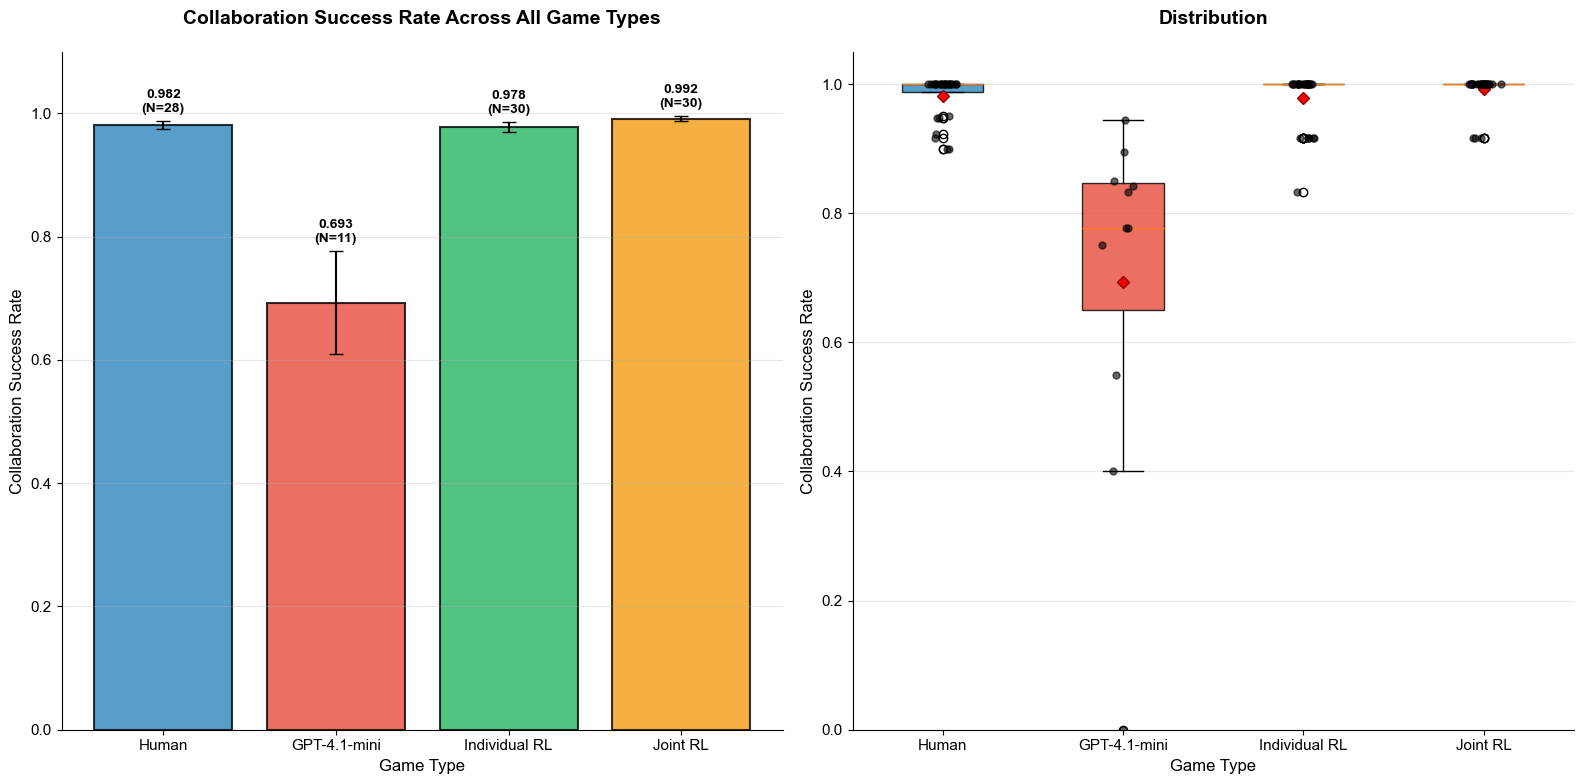

In [103]:
# Create comprehensive visualization comparing all four game types
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Bar plot with error bars showing collaboration success across all game types
ax1 = axes[0]

# Order the game types for better presentation
game_type_order = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
game_type_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
colors = [CONDITION_COLORS[gt] for gt in game_type_order]

# Prepare data for plotting
plot_data = []
plot_errors = []
plot_ns = []

for game_type in game_type_order:
    data = merged_data[merged_data['game_type'] == game_type]['success_rate']
    if len(data) > 0:
        plot_data.append(data.mean())
        plot_errors.append(data.std() / np.sqrt(len(data)))  # Standard error
        plot_ns.append(len(data))
    else:
        plot_data.append(0)
        plot_errors.append(0)
        plot_ns.append(0)

# Create bar plot
bars = ax1.bar(game_type_labels, plot_data, yerr=plot_errors, capsize=5,
               alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels and sample sizes on bars
for i, (bar, mean_val, error_val, n) in enumerate(zip(bars, plot_data, plot_errors, plot_ns)):
    ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.01,
            f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_title('Collaboration Success Rate Across All Game Types',
              fontweight='bold', pad=20)
ax1.set_ylabel('Collaboration Success Rate')
ax1.set_xlabel('Game Type')
ax1.set_ylim(0, 1.1)
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Box plot showing distribution of individual success rates
ax2 = axes[1]

# Prepare data for box plot
box_data = []
box_labels = []
box_colors = []

for game_type in game_type_order:
    data = merged_data[merged_data['game_type'] == game_type]['success_rate']
    if len(data) > 0:
        box_data.append(data.values)
        box_labels.append(game_type_labels[game_type_order.index(game_type)])
        box_colors.append(CONDITION_COLORS[game_type])

# Create box plot
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                 showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

# Add strip plot overlay
for i, game_type in enumerate(game_type_order):
    data = merged_data[merged_data['game_type'] == game_type]['success_rate']
    if len(data) > 0:
        x_positions = np.random.normal(i+1, 0.04, size=len(data))
        ax2.scatter(x_positions, data, color='black', alpha=0.6, s=25, zorder=3)

ax2.set_title('Distribution', fontweight='bold', pad=20)
ax2.set_ylabel('Collaboration Success Rate')
ax2.set_xlabel('Game Type')
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('merged_collaboration_success_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Step 6: Create Summary Table and Save Results

In [104]:
print("=== STATISTICAL ANALYSIS ACROSS ALL GAME TYPES ===")

# Overall descriptive statistics
print("\nDescriptive Statistics by Game Type:")
for game_type in game_type_order:
    data = merged_data[merged_data['game_type'] == game_type]['success_rate']
    if len(data) > 0:
        label = game_type_labels[game_type_order.index(game_type)]
        print(f"{label}: M = {data.mean():.3f}, SD = {data.std():.3f}, N = {len(data)}, Range = [{data.min():.3f}, {data.max():.3f}]")

# Pairwise comparisons between all game types
print("\n\nPairwise Comparisons (t-tests):")

comparison_results = []

for i, j in combinations(range(len(game_type_order)), 2):
    type1, type2 = game_type_order[i], game_type_order[j]
    label1, label2 = game_type_labels[i], game_type_labels[j]

    data1 = merged_data[merged_data['game_type'] == type1]['success_rate']
    data2 = merged_data[merged_data['game_type'] == type2]['success_rate']

    if len(data1) >= 3 and len(data2) >= 3:
        # Perform independent t-test
        t_stat, p_value = stats.ttest_ind(data1, data2)

        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(data1) - 1) * data1.std()**2 +
                             (len(data2) - 1) * data2.std()**2) /
                            (len(data1) + len(data2) - 2))
        cohens_d = (data1.mean() - data2.mean()) / pooled_std

        # Effect size interpretation
        effect_size = "Small" if abs(cohens_d) < 0.5 else "Medium" if abs(cohens_d) < 0.8 else "Large"

        # Significance level
        sig_level = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

        print(f"\n{label1} vs {label2}:")
        print(f"  {label1}: {data1.mean():.3f} ± {data1.std():.3f} (N={len(data1)})")
        print(f"  {label2}: {data2.mean():.3f} ± {data2.std():.3f} (N={len(data2)})")
        print(f"  t({len(data1)+len(data2)-2}) = {t_stat:.3f}, p = {p_value:.3f}, d = {cohens_d:.3f} ({effect_size})")
        print(f"  Significance: {sig_level}")

        comparison_results.append({
            'Comparison': f'{label1} vs {label2}',
            'Mean_Diff': data1.mean() - data2.mean(),
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'effect_size': effect_size,
            'significance': sig_level
        })
    else:
        print(f"\n{label1} vs {label2}: Insufficient data for comparison")

# Test each condition against chance level (0.5)
print("\n\nTesting Against Chance Level (0.5):")
for i, game_type in enumerate(game_type_order):
    data = merged_data[merged_data['game_type'] == game_type]['success_rate']
    label = game_type_labels[i]

    if len(data) >= 3:
        t_stat, p_value = stats.ttest_1samp(data, 0.5)
        sig_level = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{label}: M = {data.mean():.3f}, t({len(data)-1}) = {t_stat:.3f}, p = {p_value:.3f} {sig_level}")
    else:
        print(f"{label}: Insufficient data (N = {len(data)})")

# Save comparison results
if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df.to_csv('merged_collaboration_pairwise_comparisons.csv', index=False)
    print("\n✓ Pairwise comparison results saved to merged_collaboration_pairwise_comparisons.csv")

=== STATISTICAL ANALYSIS ACROSS ALL GAME TYPES ===

Descriptive Statistics by Game Type:
Human: M = 0.982, SD = 0.034, N = 28, Range = [0.900, 1.000]
GPT-4.1-mini: M = 0.693, SD = 0.278, N = 11, Range = [0.000, 0.944]
Individual RL: M = 0.978, SD = 0.043, N = 30, Range = [0.833, 1.000]
Joint RL: M = 0.992, SD = 0.025, N = 30, Range = [0.917, 1.000]


Pairwise Comparisons (t-tests):

Human vs GPT-4.1-mini:
  Human: 0.982 ± 0.034 (N=28)
  GPT-4.1-mini: 0.693 ± 0.278 (N=11)
  t(37) = 5.499, p = 0.000, d = 1.957 (Large)
  Significance: ***

Human vs Individual RL:
  Human: 0.982 ± 0.034 (N=28)
  Individual RL: 0.978 ± 0.043 (N=30)
  t(56) = 0.370, p = 0.713, d = 0.097 (Small)
  Significance: ns

Human vs Joint RL:
  Human: 0.982 ± 0.034 (N=28)
  Joint RL: 0.992 ± 0.025 (N=30)
  t(56) = -1.281, p = 0.205, d = -0.337 (Small)
  Significance: ns

GPT-4.1-mini vs Individual RL:
  GPT-4.1-mini: 0.693 ± 0.278 (N=11)
  Individual RL: 0.978 ± 0.043 (N=30)
  t(39) = -5.545, p = 0.000, d = -1.955 (La

## Step 7: Load Questionnaire Data


In [105]:
print("=== LOADING QUESTIONNAIRE DATA ===")

# Initialize classification_df to avoid NameError
classification_df = pd.DataFrame()

# Load game type classification data first
try:
    classification_df = pd.read_csv('human-human-with-gpt-fallback/file_classification_summary.csv')
    print(f"Loaded game type classifications for {len(classification_df)} files")
except Exception as e:
    print(f"Error loading classification data: {e}")
    classification_df = pd.DataFrame()

# Load Human-RL questionnaire data
rl_questionnaire_data = []
rl_quest_files = glob.glob('human-RLs/data-original/*.xlsx')

print(f"\nLoading Human-RL questionnaire data from {len(rl_quest_files)} files...")

for file in rl_quest_files:
    try:
        excel_file = pd.ExcelFile(file)
        if 'Questionnaire Data' in excel_file.sheet_names and 'Experiment Data' in excel_file.sheet_names:
            # Load questionnaire data
            quest_df = pd.read_excel(file, sheet_name='Questionnaire Data')

            # Load experiment data to get rlAgentType
            exp_df = pd.read_excel(file, sheet_name='Experiment Data')

            # Get the unique rlAgentType from experiment data
            if 'rlAgentType' in exp_df.columns and len(exp_df) > 0:
                rl_agent_type = exp_df['rlAgentType'].iloc[0]  # Get the first (should be consistent across trials)

                # Add metadata to questionnaire data
                quest_df['file_id'] = os.path.basename(file)
                quest_df['study'] = 'Human-RL'
                quest_df['rlAgentType'] = rl_agent_type

                # Map RL agent type to game type
                quest_df['game_type'] = quest_df['rlAgentType'].map({
                    'individual': 'individual_rl',
                    'joint': 'joint_rl'
                })

                rl_questionnaire_data.append(quest_df)
    except Exception as e:
        print(f"Error loading RL questionnaire from {file}: {e}")

# Combine RL questionnaire data
if rl_questionnaire_data:
    rl_questionnaire_df = pd.concat(rl_questionnaire_data, ignore_index=True)
    print(f"Human-RL questionnaire data: {len(rl_questionnaire_df)} responses")
    print(f"Game types: {rl_questionnaire_df['game_type'].value_counts()}")
else:
    rl_questionnaire_df = pd.DataFrame()
    print("No Human-RL questionnaire data found")

# Load Human-Human-GPT questionnaire data
hh_gpt_questionnaire_data = []
hh_gpt_quest_files = glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx')

print(f"\nLoading Human-Human-GPT questionnaire data from {len(hh_gpt_quest_files)} files...")

for file in hh_gpt_quest_files:
    try:
        excel_file = pd.ExcelFile(file)
        if 'Questionnaire' in excel_file.sheet_names and 'Meta' in excel_file.sheet_names:
            # Load questionnaire data
            quest_df = pd.read_excel(file, sheet_name='Questionnaire')

            # Load meta data to get partnerAgentType
            meta_df = pd.read_excel(file, sheet_name='Meta')

            # Extract partnerAgentType from meta data (check if it's in the first column)
            partner_agent_type = None
            if len(meta_df.columns) >= 2 and 'partnerAgentType' in meta_df.iloc[:, 0].values:
                partner_type_row = meta_df[meta_df.iloc[:, 0] == 'partnerAgentType']
                if not partner_type_row.empty:
                    partner_agent_type = partner_type_row.iloc[0, 1]  # Get value from second column

            if partner_agent_type:
                # Add metadata to questionnaire data
                quest_df['file_id'] = os.path.basename(file)
                quest_df['study'] = 'Human-Human-GPT'
                quest_df['partnerAgentType'] = partner_agent_type

                # Map partner agent type to game type
                quest_df['game_type'] = quest_df['partnerAgentType'].map({
                    'human': 'human',
                    'gpt-4.1-mini': 'gpt-4.1-mini'
                })

                # Handle mixed types by checking if mapping failed
                if quest_df['game_type'].isna().any():
                    quest_df['game_type'] = 'mixed'  # Default to mixed if unknown partner type

                hh_gpt_questionnaire_data.append(quest_df)

    except Exception as e:
        print(f"Error loading HH-GPT questionnaire from {file}: {e}")

# Combine HH-GPT questionnaire data and merge with game type classification if needed
if hh_gpt_questionnaire_data:
    hh_gpt_questionnaire_df = pd.concat(hh_gpt_questionnaire_data, ignore_index=True)

    # Use classification data as fallback for mixed types and to get more accurate classifications
    if not classification_df.empty:
        # Merge with classification data to get mixed types and handle any missing game_types
        hh_gpt_questionnaire_df = hh_gpt_questionnaire_df.merge(
            classification_df[['file_name', 'game_type']],
            left_on='file_id',
            right_on='file_name',
            how='left',
            suffixes=('', '_classified')
        )

        # Use classified game_type if available (it's more accurate for mixed types)
        hh_gpt_questionnaire_df['game_type'] = hh_gpt_questionnaire_df['game_type_classified'].fillna(hh_gpt_questionnaire_df['game_type'])
        hh_gpt_questionnaire_df = hh_gpt_questionnaire_df.drop(['game_type_classified', 'file_name'], axis=1, errors='ignore')

    print(f"Human-Human-GPT questionnaire data: {len(hh_gpt_questionnaire_df)} responses")
    print(f"Game types: {hh_gpt_questionnaire_df['game_type'].value_counts()}")
else:
    hh_gpt_questionnaire_df = pd.DataFrame()
    print("No Human-Human-GPT questionnaire data found")

print(f"\n=== QUESTIONNAIRE DATA LOADING SUMMARY ===")
print(f"Total Human-RL responses: {len(rl_questionnaire_df) if not rl_questionnaire_df.empty else 0}")
print(f"Total Human-Human-GPT responses: {len(hh_gpt_questionnaire_df) if not hh_gpt_questionnaire_df.empty else 0}")

total_responses = 0
if not rl_questionnaire_df.empty:
    total_responses += len(rl_questionnaire_df)
if not hh_gpt_questionnaire_df.empty:
    total_responses += len(hh_gpt_questionnaire_df)

print(f"Grand total questionnaire responses: {total_responses}")

=== LOADING QUESTIONNAIRE DATA ===
Loaded game type classifications for 50 files

Loading Human-RL questionnaire data from 60 files...
Human-RL questionnaire data: 60 responses
Game types: game_type
joint_rl         30
individual_rl    30
Name: count, dtype: int64

Loading Human-Human-GPT questionnaire data from 50 files...
Human-Human-GPT questionnaire data: 50 responses
Game types: game_type
human           28
gpt-4.1-mini    11
mixed           11
Name: count, dtype: int64

=== QUESTIONNAIRE DATA LOADING SUMMARY ===
Total Human-RL responses: 60
Total Human-Human-GPT responses: 50
Grand total questionnaire responses: 110


# Total Steps Analysis: Efficiency Comparison Across Game Types

This section analyzes the total number of steps taken to complete trials across all four game types:
- **Human**: Pure human-human collaboration 
- **GPT-4.1-mini**: Human-GPT collaboration
- **Individual RL**: Human collaborating with individually-trained RL agent
- **Joint RL**: Human collaborating with jointly-trained RL agent

We examine task efficiency by comparing the total steps required for successful collaboration.


In [106]:
print("=== STANDARDIZING QUESTIONNAIRE DATA ===")

# Define standard ordinal mappings based on TimelineManager.js source code
# AI Detection: "Do you think the other player is a person or an AI?"
ai_detection_order = [
    'Definitely a person',
    'Probably a person',
    'Not sure',
    'Probably an AI',
    'Definitely an AI'
]

# Collaboration Rating: "To what extent do you think the other player was a good collaborator?"
collaboration_order = [
    'Very poor collaborator',
    'Poor collaborator',
    'Neutral',
    'Good collaborator',
    'Very good collaborator'
]

# Play Again: "Would you play with the other player again?"
play_again_order = [
    'Definitely not play again',
    'Probably not play again',
    'Not sure',
    'Probably play again',
    'Definitely play again'
]

print("✅ Using questionnaire mappings from TimelineManager.js source code")
print(f"AI Detection scale: {ai_detection_order[0]} → {ai_detection_order[-1]}")
print(f"Collaboration scale: {collaboration_order[0]} → {collaboration_order[-1]}")
print(f"Play Again scale: {play_again_order[0]} → {play_again_order[-1]}")

# Standardize Human-RL questionnaire data
if not rl_questionnaire_df.empty:
    rl_quest_std = rl_questionnaire_df[['study', 'game_type', 'ai_detection', 'collaboration_rating', 'play_again']].copy()
    print(f"\nHuman-RL standardized: {len(rl_quest_std)} responses")
    print(f"Game types: {rl_quest_std['game_type'].value_counts()}")
else:
    rl_quest_std = pd.DataFrame()

# Standardize Human-Human-GPT questionnaire data
if not hh_gpt_questionnaire_df.empty:
    hh_gpt_quest_std = hh_gpt_questionnaire_df[['study', 'game_type', 'ai_detection', 'collaboration_rating', 'play_again']].copy()
    print(f"Human-Human-GPT standardized: {len(hh_gpt_quest_std)} responses")
    print(f"Game types: {hh_gpt_quest_std['game_type'].value_counts()}")
else:
    hh_gpt_quest_std = pd.DataFrame()

# Combine questionnaire data
questionnaire_dfs = [df for df in [rl_quest_std, hh_gpt_quest_std] if not df.empty]

if questionnaire_dfs:
    merged_questionnaire_df = pd.concat(questionnaire_dfs, ignore_index=True)

    # Filter to only game types we're analyzing (remove mixed for cleaner analysis)
    analysis_game_types = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    merged_questionnaire_df = merged_questionnaire_df[
        merged_questionnaire_df['game_type'].isin(analysis_game_types)
    ].copy()

    print(f"\n=== MERGED QUESTIONNAIRE DATA ===")
    print(f"Total responses: {len(merged_questionnaire_df)}")
    print(f"Game type distribution:")
    print(merged_questionnaire_df['game_type'].value_counts())
    print(f"Study distribution:")
    print(merged_questionnaire_df['study'].value_counts())

    # Convert to categorical for proper ordering using source code mappings
    merged_questionnaire_df['ai_detection_cat'] = pd.Categorical(
        merged_questionnaire_df['ai_detection'], categories=ai_detection_order, ordered=True
    )
    merged_questionnaire_df['collaboration_rating_cat'] = pd.Categorical(
        merged_questionnaire_df['collaboration_rating'], categories=collaboration_order, ordered=True
    )
    merged_questionnaire_df['play_again_cat'] = pd.Categorical(
        merged_questionnaire_df['play_again'], categories=play_again_order, ordered=True
    )

    print("\n✅ Questionnaire data standardized and merged successfully!")
    print("✅ Using correct ordinal mappings from TimelineManager.js source code")
    print(f"✅ Final dataset includes {len(merged_questionnaire_df)} responses across {merged_questionnaire_df['game_type'].nunique()} game types")
else:
    merged_questionnaire_df = pd.DataFrame()
    print("\n❌ No questionnaire data available for analysis")

=== STANDARDIZING QUESTIONNAIRE DATA ===
✅ Using questionnaire mappings from TimelineManager.js source code
AI Detection scale: Definitely a person → Definitely an AI
Collaboration scale: Very poor collaborator → Very good collaborator
Play Again scale: Definitely not play again → Definitely play again

Human-RL standardized: 60 responses
Game types: game_type
joint_rl         30
individual_rl    30
Name: count, dtype: int64
Human-Human-GPT standardized: 50 responses
Game types: game_type
human           28
gpt-4.1-mini    11
mixed           11
Name: count, dtype: int64

=== MERGED QUESTIONNAIRE DATA ===
Total responses: 99
Game type distribution:
game_type
joint_rl         30
individual_rl    30
human            28
gpt-4.1-mini     11
Name: count, dtype: int64
Study distribution:
study
Human-RL           60
Human-Human-GPT    39
Name: count, dtype: int64

✅ Questionnaire data standardized and merged successfully!
✅ Using correct ordinal mappings from TimelineManager.js source code
✅ F

## Step 8: Standardize and Merge Questionnaire Data


In [107]:
print("=== LOADING TRIAL-LEVEL DATA FOR STEPS ANALYSIS ===")

# Load Human-RL trial-level data for steps analysis
rl_steps_data = []
rl_quest_files = glob.glob('human-RLs/data-original/*.xlsx')

print(f"\nLoading Human-RL trial data from {len(rl_quest_files)} files...")

for file in rl_quest_files:
    try:
        excel_file = pd.ExcelFile(file)
        if 'Experiment Data' in excel_file.sheet_names:
            exp_df = pd.read_excel(file, sheet_name='Experiment Data')
            exp_df['file_id'] = os.path.basename(file)
            exp_df['study'] = 'Human-RL'

            # Filter for 2P3G trials (multiplayer) and successful collaborations
            multiplayer_trials = exp_df[
                (exp_df['experimentType'] == '2P3G') &
                (exp_df['collaborationSucceeded'] == True)
            ].copy()

            if len(multiplayer_trials) > 0:
                # Map RL agent type to our game type classification
                multiplayer_trials['game_type'] = multiplayer_trials['rlAgentType'].map({
                    'individual': 'individual_rl',
                    'joint': 'joint_rl'
                })

                # Rename distance conditions for Human-RL data
                multiplayer_trials['distanceCondition_renamed'] = multiplayer_trials.apply(
                    lambda row: rename_distance_condition_human_ai(row, 'Human-RL'), axis=1
                )

                # Calculate total steps from trajectory lengths
                def calculate_trajectory_steps(row):
                    try:
                        # Parse trajectories (they might be strings that need to be evaluated)
                        p1_traj = row['player1Trajectory']
                        p2_traj = row['player2Trajectory']

                        # Convert to list if they're strings
                        if isinstance(p1_traj, str):
                            p1_traj = ast.literal_eval(p1_traj)
                        if isinstance(p2_traj, str):
                            p2_traj = ast.literal_eval(p2_traj)

                        # Calculate lengths
                        p1_steps = len(p1_traj) if p1_traj else 0
                        p2_steps = len(p2_traj) if p2_traj else 0

                        # Total steps = p1_steps + p2_steps (combined movement steps)
                        return p1_steps + p2_steps
                    except:
                        return 0

                multiplayer_trials['total_steps'] = multiplayer_trials.apply(calculate_trajectory_steps, axis=1)
                rl_steps_data.append(multiplayer_trials)

    except Exception as e:
        print(f"Error loading RL steps data from {file}: {e}")

# Combine RL steps data
if rl_steps_data:
    rl_combined_steps = pd.concat(rl_steps_data, ignore_index=True)
    print(f"Human-RL steps data: {len(rl_combined_steps)} successful 2P3G trials")
    print(f"Game types: {rl_combined_steps['game_type'].value_counts()}")

    # Debug: Show step count statistics by game type
    if 'total_steps' in rl_combined_steps.columns:
        print(f"\nRL Step count statistics by game type:")
        for game_type in rl_combined_steps['game_type'].unique():
            if pd.notna(game_type):
                subset = rl_combined_steps[rl_combined_steps['game_type'] == game_type]['total_steps']
                print(f"  {game_type}: Mean = {subset.mean():.2f}, Median = {subset.median():.2f}, N = {len(subset)}")

        # Show renamed distance conditions
        print(f"\nRL Renamed distance conditions:")
        renamed_conditions = rl_combined_steps['distanceCondition_renamed'].value_counts()
        print(renamed_conditions)
else:
    rl_combined_steps = pd.DataFrame()
    print("No Human-RL steps data found")

# Load Human-Human-GPT trial-level data for steps analysis
hh_gpt_steps_data = []
hh_gpt_quest_files = glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx')

print(f"\nLoading Human-Human-GPT trial data from {len(hh_gpt_quest_files)} files...")

# Load classification data for game types
try:
    classification_df = pd.read_csv('human-human-with-gpt-fallback/file_classification_summary.csv')
    print(f"Loaded game type classifications for {len(classification_df)} files")
except Exception as e:
    print(f"Error loading classification data: {e}")
    classification_df = pd.DataFrame()

for file in hh_gpt_quest_files:
    try:
        excel_file = pd.ExcelFile(file)
        if 'ExperimentData' in excel_file.sheet_names:
            exp_df = pd.read_excel(file, sheet_name='ExperimentData')
            exp_df['file_id'] = os.path.basename(file)
            exp_df['study'] = 'Human-Human-GPT'

            # Filter for 2P3G trials ONLY and successful collaborations to match RL data
            multiplayer_trials = exp_df[
                (exp_df['experimentType'] == '2P3G') &
                (exp_df['collaborationSucceeded'] == True)
            ].copy()

            print(f"  File {os.path.basename(file)}: {len(exp_df)} total trials, {len(multiplayer_trials)} 2P3G successful trials")

            if len(multiplayer_trials) > 0:
                # Rename distance conditions for Human-Human-GPT data
                multiplayer_trials['distanceCondition_renamed'] = multiplayer_trials.apply(
                    lambda row: rename_distance_condition_human_ai(row, 'Human-Human-GPT'), axis=1
                )

                # Clean trajectories - remove invalid trajectories with jumps > 1
                def is_valid_trajectory(trajectory):
                    """Check if trajectory has valid consecutive steps (distance <= 1)"""
                    try:
                        if isinstance(trajectory, str):
                            trajectory = ast.literal_eval(trajectory)

                        if not trajectory or len(trajectory) < 2:
                            return True  # Single point or empty is valid

                        for i in range(1, len(trajectory)):
                            prev_pos = trajectory[i-1]
                            curr_pos = trajectory[i]

                            # Calculate Manhattan distance between consecutive positions
                            distance = abs(curr_pos[0] - prev_pos[0]) + abs(curr_pos[1] - prev_pos[1])

                            if distance > 1:  # Invalid jump
                                return False

                        return True
                    except:
                        return False  # If parsing fails, consider invalid

                # Filter out trials with invalid trajectories
                initial_count = len(multiplayer_trials)

                valid_p1_traj = multiplayer_trials['player1Trajectory'].apply(is_valid_trajectory)
                valid_p2_traj = multiplayer_trials['player2Trajectory'].apply(is_valid_trajectory)
                valid_trials_mask = valid_p1_traj & valid_p2_traj

                cleaned_trials = multiplayer_trials[valid_trials_mask].copy()
                removed_count = initial_count - len(cleaned_trials)

                print(f"  File {os.path.basename(file)}: Removed {removed_count}/{initial_count} trials with invalid trajectories")

                if len(cleaned_trials) > 0:
                    # Calculate total steps from trajectory lengths for cleaned HH-GPT data
                    def calculate_trajectory_steps_hh_gpt(row):
                        try:
                            # Parse trajectories (they might be strings that need to be evaluated)
                            p1_traj = row['player1Trajectory']
                            p2_traj = row['player2Trajectory']

                            # Convert to list if they're strings
                            if isinstance(p1_traj, str):
                                p1_traj = ast.literal_eval(p1_traj)
                            if isinstance(p2_traj, str):
                                p2_traj = ast.literal_eval(p2_traj)

                            # Calculate lengths
                            p1_steps = len(p1_traj) if p1_traj else 0
                            p2_steps = len(p2_traj) if p2_traj else 0

                            # Total steps = p1_steps + p2_steps (combined movement steps)
                            return p1_steps + p2_steps
                        except:
                            return 0

                    cleaned_trials['total_steps'] = cleaned_trials.apply(calculate_trajectory_steps_hh_gpt, axis=1)
                    hh_gpt_steps_data.append(cleaned_trials)
                else:
                    print(f"  Warning: All trials removed from {os.path.basename(file)} due to invalid trajectories")

    except Exception as e:
        print(f"Error loading HH-GPT steps data from {file}: {e}")

# Combine HH-GPT steps data and merge with game type classification
if hh_gpt_steps_data:
    hh_gpt_combined_steps = pd.concat(hh_gpt_steps_data, ignore_index=True)

    # Merge with game type classification
    if not classification_df.empty:
        hh_gpt_combined_steps = hh_gpt_combined_steps.merge(
            classification_df[['file_name', 'game_type']],
            left_on='file_id',
            right_on='file_name',
            how='left'
        )

    print(f"Human-Human-GPT steps data: {len(hh_gpt_combined_steps)} successful 2P3G trials (after trajectory cleaning)")
    print(f"Game types: {hh_gpt_combined_steps['game_type'].value_counts()}")

    # Debug: Show step count statistics by game type
    if 'total_steps' in hh_gpt_combined_steps.columns:
        print(f"\nHH-GPT Step count statistics by game type:")
        for game_type in hh_gpt_combined_steps['game_type'].unique():
            if pd.notna(game_type):
                subset = hh_gpt_combined_steps[hh_gpt_combined_steps['game_type'] == game_type]['total_steps']
                print(f"  {game_type}: Mean = {subset.mean():.2f}, Median = {subset.median():.2f}, N = {len(subset)}")

        # Show renamed distance conditions
        print(f"\nHH-GPT Renamed distance conditions:")
        renamed_conditions = hh_gpt_combined_steps['distanceCondition_renamed'].value_counts()
        print(renamed_conditions)
else:
    hh_gpt_combined_steps = pd.DataFrame()
    print("No Human-Human-GPT steps data found")

print(f"\n=== STEPS DATA SUMMARY ===")
print(f"Total Human-RL trials: {len(rl_combined_steps)}")
print(f"Total Human-Human-GPT trials: {len(hh_gpt_combined_steps)}")
print(f"Grand total successful trials: {len(rl_combined_steps) + len(hh_gpt_combined_steps)}")
print(f"\n✅ Using trajectory-based calculation: total_steps = p1_steps + p2_steps")
print(f"✅ Human-Human-GPT data cleaned: Removed trials with invalid trajectories (jumps > 1 step)")
print(f"✅ Distance conditions renamed to be more intuitive (closer_to_human vs closer_to_AI)")


=== LOADING TRIAL-LEVEL DATA FOR STEPS ANALYSIS ===

Loading Human-RL trial data from 60 files...
Human-RL steps data: 709 successful 2P3G trials
Game types: game_type
joint_rl         357
individual_rl    352
Name: count, dtype: int64

RL Step count statistics by game type:
  joint_rl: Mean = 37.85, Median = 37.00, N = 357
  individual_rl: Mean = 37.06, Median = 36.00, N = 352

RL Renamed distance conditions:
distanceCondition_renamed
no_new_goal        180
equal_to_both      178
closer_to_human    177
closer_to_AI       174
Name: count, dtype: int64

Loading Human-Human-GPT trial data from 50 files...
Loaded game type classifications for 50 files
  File experiment_data_5a5bd24be0cf3d000126849e_room_9922acb2-7db1-47ea-b369-ff389b4e47a5_2025-09-13T18-17-31-453Z.xlsx: 35 total trials, 12 2P3G successful trials
  File experiment_data_5a5bd24be0cf3d000126849e_room_9922acb2-7db1-47ea-b369-ff389b4e47a5_2025-09-13T18-17-31-453Z.xlsx: Removed 0/12 trials with invalid trajectories
  File exper

## Step 9: Load and Analyze Total Steps Data


In [108]:
print("=== MERGING AND ANALYZING TOTAL STEPS DATA ===")

# Combine both datasets for steps analysis
steps_datasets = []
if not rl_combined_steps.empty:
    # Select relevant columns for RL data, including renamed distanceCondition
    rl_columns = ['game_type', 'total_steps', 'study', 'file_id']
    if 'distanceCondition_renamed' in rl_combined_steps.columns:
        rl_columns.append('distanceCondition_renamed')
    elif 'distanceCondition' in rl_combined_steps.columns:
        rl_columns.append('distanceCondition')
    rl_steps_subset = rl_combined_steps[rl_columns].copy()

    # Rename the column to standardize
    if 'distanceCondition_renamed' in rl_steps_subset.columns:
        rl_steps_subset['distanceCondition'] = rl_steps_subset['distanceCondition_renamed']
        rl_steps_subset = rl_steps_subset.drop('distanceCondition_renamed', axis=1)

    steps_datasets.append(rl_steps_subset)
    print(f"Human-RL: Using trajectory-based step calculation with renamed distance conditions")

if not hh_gpt_combined_steps.empty:
    # Select relevant columns for HH-GPT data, including renamed distanceCondition
    hh_gpt_columns = ['game_type', 'total_steps', 'study', 'file_id']
    if 'distanceCondition_renamed' in hh_gpt_combined_steps.columns:
        hh_gpt_columns.append('distanceCondition_renamed')
    elif 'distanceCondition' in hh_gpt_combined_steps.columns:
        hh_gpt_columns.append('distanceCondition')
    hh_gpt_steps_subset = hh_gpt_combined_steps[hh_gpt_columns].copy()

    # Rename the column to standardize
    if 'distanceCondition_renamed' in hh_gpt_steps_subset.columns:
        hh_gpt_steps_subset['distanceCondition'] = hh_gpt_steps_subset['distanceCondition_renamed']
        hh_gpt_steps_subset = hh_gpt_steps_subset.drop('distanceCondition_renamed', axis=1)

    steps_datasets.append(hh_gpt_steps_subset)
    print(f"Human-Human-GPT: Using trajectory-based step calculation with renamed distance conditions")

# Combine all steps data
if steps_datasets:
    merged_steps_data = pd.concat(steps_datasets, ignore_index=True)

    # Remove any NaN values and ensure we have valid step counts
    merged_steps_data = merged_steps_data.dropna(subset=['total_steps'])
    merged_steps_data = merged_steps_data[merged_steps_data['total_steps'] > 0]

    print(f"\nMerged steps dataset:")
    print(f"Total trials: {len(merged_steps_data)}")
    print(f"Game types: {merged_steps_data['game_type'].value_counts()}")
    print(f"Studies: {merged_steps_data['study'].value_counts()}")
    print(f"Available columns: {list(merged_steps_data.columns)}")

    # Show renamed distance conditions across all data
    if 'distanceCondition' in merged_steps_data.columns:
        print(f"\nRenamed Distance Conditions (All Studies):")
        distance_counts = merged_steps_data['distanceCondition'].value_counts()
        print(distance_counts)

    # Calculate participant-level means first
    # For RL data, we need to extract participant ID from file_id
    def extract_participant_id(file_id, study):
        if study == 'Human-RL':
            # Extract participant ID from RL file names (format: experiment_data_PARTICIPANTID_timestamp.xlsx)
            parts = file_id.split('_')
            if len(parts) >= 3:
                return parts[2]  # participant ID is the 3rd part
        elif study == 'Human-Human-GPT':
            # Extract participant ID from HH-GPT file names
            parts = file_id.split('_')
            if len(parts) >= 3:
                return parts[2]  # participant ID is the 3rd part
        return file_id  # fallback to file_id if extraction fails

    merged_steps_data['participant_id'] = merged_steps_data.apply(
        lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
    )

    # Calculate participant-level mean steps
    participant_steps_means = merged_steps_data.groupby(['participant_id', 'game_type', 'study'])['total_steps'].mean().reset_index()
    participant_steps_means['participant_mean_steps'] = participant_steps_means['total_steps']

    print(f"\nParticipant-level data:")
    print(f"Total participants: {len(participant_steps_means)}")
    print(f"Game types: {participant_steps_means['game_type'].value_counts()}")

    # Calculate summary statistics by game type (using participant means)
    steps_summary = participant_steps_means.groupby('game_type')['participant_mean_steps'].agg(['count', 'mean', 'std', 'median']).round(2)
    steps_summary['se'] = (steps_summary['std'] / np.sqrt(steps_summary['count'])).round(2)

    print(f"\nSteps Summary by Game Type (Participant-Level Means):")
    print(steps_summary)

    # Compare different distance conditions by game type
    if 'distanceCondition' in merged_steps_data.columns:
        print(f"\n=== STEPS BY DISTANCE CONDITION COMPARISON ===")

        # Calculate trial-level means by distance condition and game type
        distance_steps_summary = merged_steps_data.groupby(['game_type', 'distanceCondition'])['total_steps'].agg(['count', 'mean', 'std']).round(2)
        print("Trial-level steps by game type and distance condition:")
        print(distance_steps_summary)

        # Focus on key conditions for comparison
        key_conditions = ['closer_to_human', 'closer_to_AI', 'equal_to_both', 'no_new_goal']
        key_data = merged_steps_data[merged_steps_data['distanceCondition'].isin(key_conditions)]

        if len(key_data) > 0:
            print(f"\nKey Distance Conditions Analysis (N={len(key_data)} trials):")
            for game_type in ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']:
                if game_type in key_data['game_type'].values:
                    print(f"\n{game_type.upper()}:")
                    game_data = key_data[key_data['game_type'] == game_type]
                    for condition in key_conditions:
                        condition_data = game_data[game_data['distanceCondition'] == condition]
                        if len(condition_data) > 0:
                            mean_steps = condition_data['total_steps'].mean()
                            print(f"  {condition}: {mean_steps:.1f} steps (N={len(condition_data)})")

else:
    merged_steps_data = pd.DataFrame()
    print("No steps data available for analysis")

=== MERGING AND ANALYZING TOTAL STEPS DATA ===
Human-RL: Using trajectory-based step calculation with renamed distance conditions
Human-Human-GPT: Using trajectory-based step calculation with renamed distance conditions

Merged steps dataset:
Total trials: 1180
Game types: game_type
joint_rl         357
individual_rl    352
human            294
gpt-4.1-mini      91
mixed             86
Name: count, dtype: int64
Studies: study
Human-RL           709
Human-Human-GPT    471
Name: count, dtype: int64
Available columns: ['game_type', 'total_steps', 'study', 'file_id', 'distanceCondition']

Renamed Distance Conditions (All Studies):
distanceCondition
equal_to_both      302
no_new_goal        299
closer_to_AI       290
closer_to_human    289
Name: count, dtype: int64

Participant-level data:
Total participants: 108
Game types: game_type
individual_rl    30
joint_rl         30
human            28
gpt-4.1-mini     10
mixed            10
Name: count, dtype: int64

Steps Summary by Game Type (Par

=== TOTAL STEPS VISUALIZATION (PARTICIPANT-LEVEL MEANS) ===


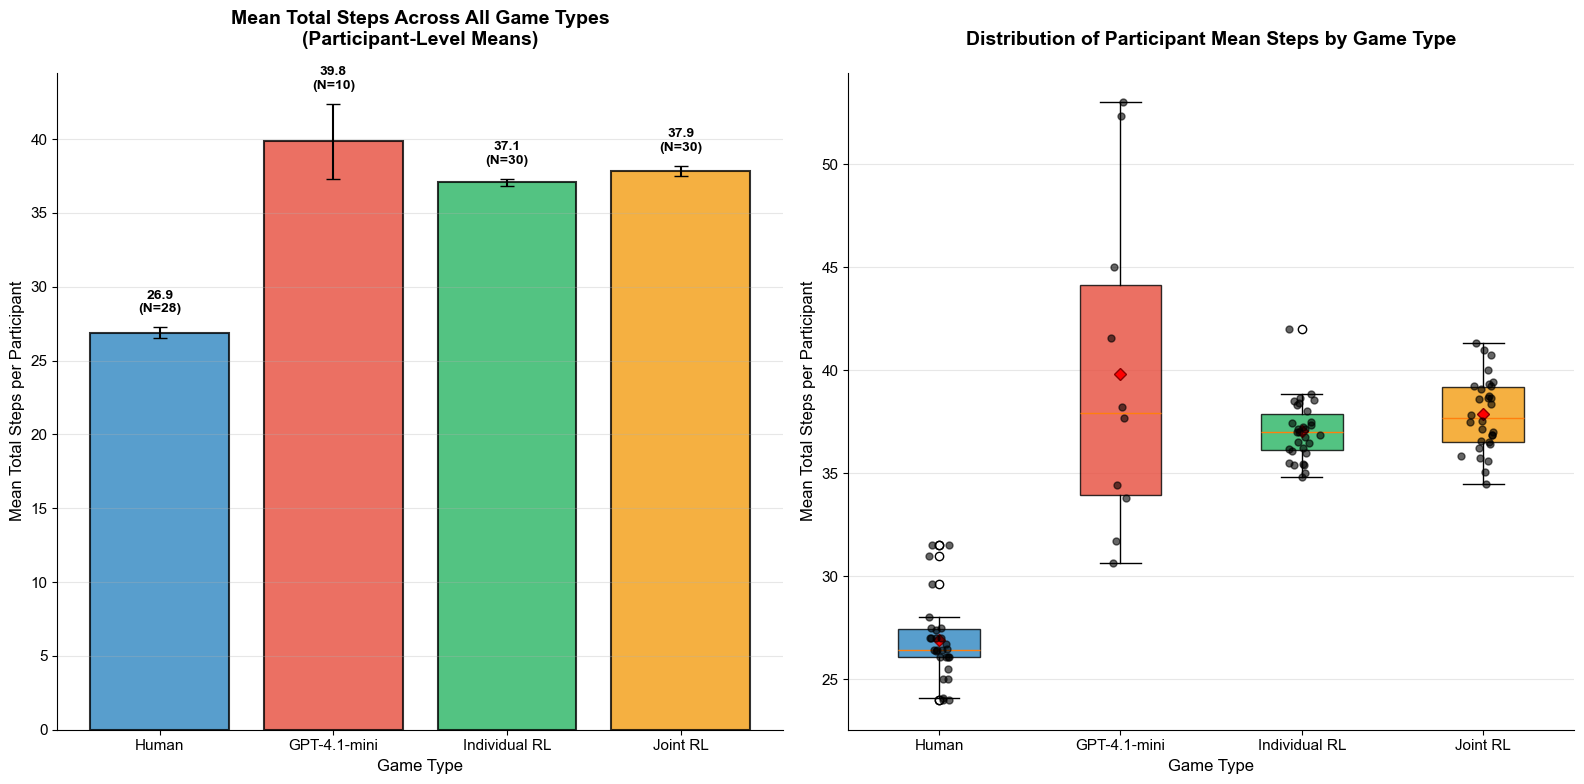


=== DETAILED STEPS STATISTICS (PARTICIPANT-LEVEL) ===

Human:
  Mean: 26.88 ± 1.98 steps
  Median: 26.4 steps
  Range: 24.0 - 31.5 steps
  N participants: 28

GPT-4.1-mini:
  Mean: 39.84 ± 8.04 steps
  Median: 37.9 steps
  Range: 30.7 - 53.0 steps
  N participants: 10

Individual RL:
  Mean: 37.06 ± 1.48 steps
  Median: 37.0 steps
  Range: 34.8 - 42.0 steps
  N participants: 30

Joint RL:
  Mean: 37.86 ± 1.78 steps
  Median: 37.7 steps
  Range: 34.5 - 41.3 steps
  N participants: 30


In [109]:
# Step 10: Total Steps Visualization (now that data is loaded)
if 'merged_steps_data' in locals() and not merged_steps_data.empty and 'participant_steps_means' in locals() and not participant_steps_means.empty:
    print("=== TOTAL STEPS VISUALIZATION (PARTICIPANT-LEVEL MEANS) ===")

    # Use the same game type order and colors as collaboration analysis
    steps_game_types = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    steps_game_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
    steps_colors = [CONDITION_COLORS[gt] for gt in steps_game_types]

    # Filter to available game types in participant steps data
    available_steps_types = [gt for gt in steps_game_types if gt in participant_steps_means['game_type'].values]
    available_steps_labels = [steps_game_labels[steps_game_types.index(gt)] for gt in available_steps_types]
    available_steps_colors = [steps_colors[steps_game_types.index(gt)] for gt in available_steps_types]

    # Create comprehensive visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Bar plot with error bars showing mean steps (participant-level)
    plot_data = []
    plot_errors = []
    plot_ns = []

    for game_type in available_steps_types:
        participant_data = participant_steps_means[participant_steps_means['game_type'] == game_type]['participant_mean_steps']
        if len(participant_data) > 0:
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))  # Standard error
            plot_ns.append(len(participant_data))
        else:
            plot_data.append(0)
            plot_errors.append(0)
            plot_ns.append(0)

    # Create bar plot
    bars = ax1.bar(available_steps_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_steps_colors, edgecolor='black', linewidth=1.5)

    # Add value labels and sample sizes on bars
    for i, (bar, mean_val, error_val, n) in enumerate(zip(bars, plot_data, plot_errors, plot_ns)):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + max(plot_data)*0.02,
                f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Mean Total Steps Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
    ax1.set_ylabel('Mean Total Steps per Participant')
    ax1.set_xlabel('Game Type')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Plot 2: Box plot showing distribution of participant means
    box_data = []
    box_labels = []
    box_colors = []

    for game_type in available_steps_types:
        participant_data = participant_steps_means[participant_steps_means['game_type'] == game_type]['participant_mean_steps']
        if len(participant_data) > 0:
            box_data.append(participant_data.values)
            box_labels.append(available_steps_labels[available_steps_types.index(game_type)])
            box_colors.append(available_steps_colors[available_steps_types.index(game_type)])

    # Create box plot
    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    # Add strip plot overlay with participant means
    for i, game_type in enumerate(available_steps_types):
        participant_data = participant_steps_means[participant_steps_means['game_type'] == game_type]['participant_mean_steps']
        if len(participant_data) > 0:
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution of Participant Mean Steps by Game Type', fontweight='bold', pad=20)
    ax2.set_ylabel('Mean Total Steps per Participant')
    ax2.set_xlabel('Game Type')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_total_steps_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed statistics (participant-level)
    print(f"\n=== DETAILED STEPS STATISTICS (PARTICIPANT-LEVEL) ===")
    for game_type in available_steps_types:
        participant_data = participant_steps_means[participant_steps_means['game_type'] == game_type]['participant_mean_steps']
        label = available_steps_labels[available_steps_types.index(game_type)]
        if len(participant_data) > 0:
            print(f"\n{label}:")
            print(f"  Mean: {participant_data.mean():.2f} ± {participant_data.std():.2f} steps")
            print(f"  Median: {participant_data.median():.1f} steps")
            print(f"  Range: {participant_data.min():.1f} - {participant_data.max():.1f} steps")
            print(f"  N participants: {len(participant_data)}")

else:
    print("Steps data will be available after running cell 24 (merge steps data)")

=== HUMAN TRAJECTORY LENGTH ANALYSIS ===
Found trajectory columns: player1=None, player2=None
Data shape: (1180, 7)
Available columns: ['game_type', 'total_steps', 'study', 'file_id', 'distanceCondition', 'participant_id', 'human_trajectory_length']
Trajectory-related columns: ['human_trajectory_length']
Player-related columns: []
First few rows of relevant data:
      study game_type  human_trajectory_length
0  Human-RL  joint_rl                        0
1  Human-RL  joint_rl                        0
2  Human-RL  joint_rl                        0
Row 0: study=Human-RL, game_type=joint_rl
Row 1: study=Human-RL, game_type=joint_rl
Row 2: study=Human-RL, game_type=joint_rl

Calculated trajectory lengths:
Min: 0
Max: 0
Mean: 0.0
Non-zero values: 0
Sample of calculated lengths: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


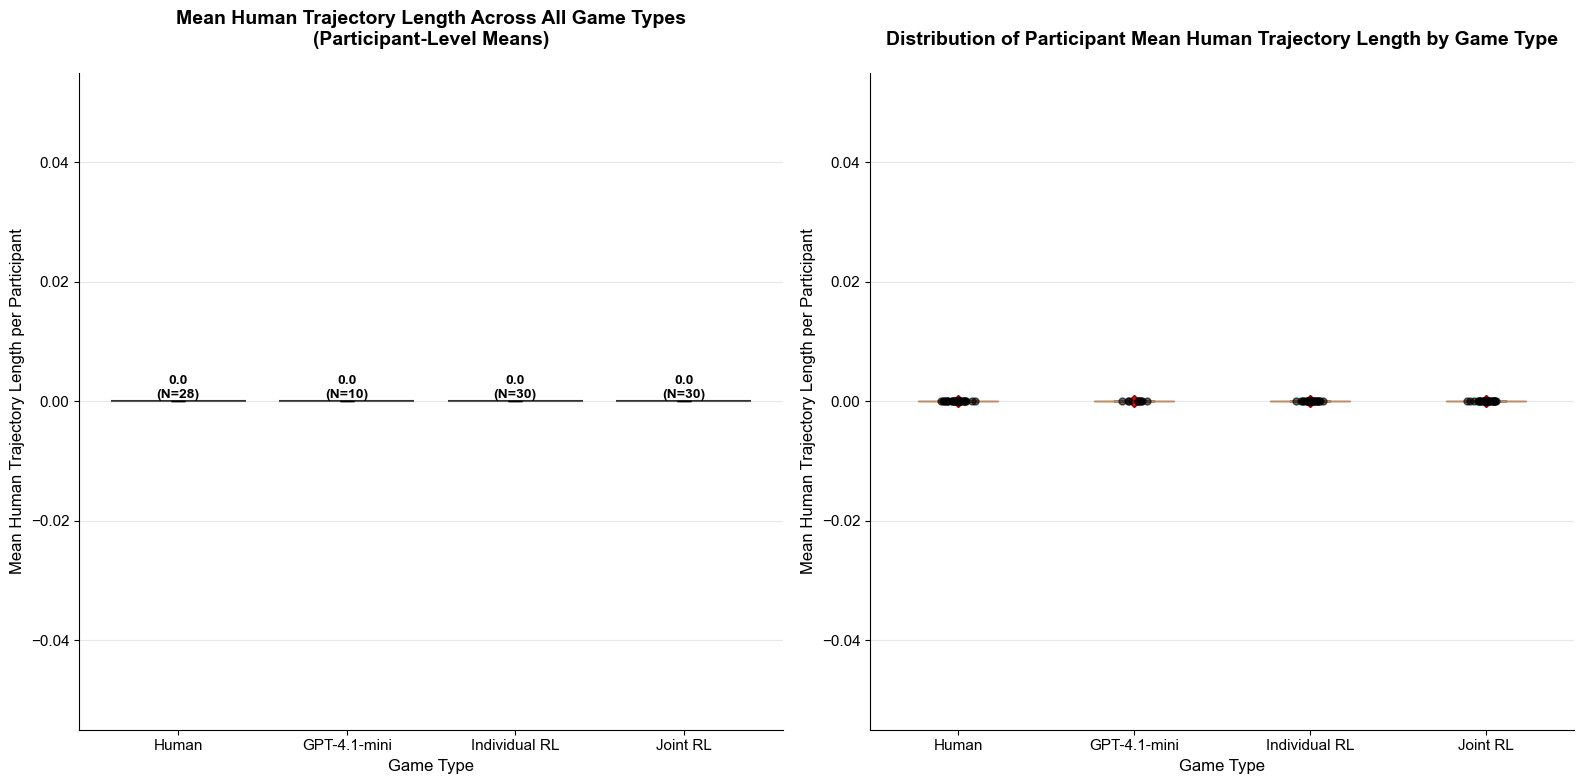


=== DETAILED HUMAN TRAJECTORY LENGTH STATISTICS (PARTICIPANT-LEVEL) ===

Human:
  Mean: 0.00 ± 0.00 steps
  Median: 0.0 steps
  Range: 0.0 - 0.0 steps
  N participants: 28

GPT-4.1-mini:
  Mean: 0.00 ± 0.00 steps
  Median: 0.0 steps
  Range: 0.0 - 0.0 steps
  N participants: 10

Individual RL:
  Mean: 0.00 ± 0.00 steps
  Median: 0.0 steps
  Range: 0.0 - 0.0 steps
  N participants: 30

Joint RL:
  Mean: 0.00 ± 0.00 steps
  Median: 0.0 steps
  Range: 0.0 - 0.0 steps
  N participants: 30

✅ Human trajectory length analysis complete


In [133]:
# Human Trajectory Length Analysis
if 'merged_steps_data' in locals() and not merged_steps_data.empty:
    print("=== HUMAN TRAJECTORY LENGTH ANALYSIS ===")

            # Find the correct trajectory column names
    p1_traj_col = None
    p2_traj_col = None
    for col in merged_steps_data.columns:
        if 'player1' in col.lower() and 'trajectory' in col.lower():
            p1_traj_col = col
        elif 'player2' in col.lower() and 'trajectory' in col.lower():
            p2_traj_col = col

    print(f"Found trajectory columns: player1={p1_traj_col}, player2={p2_traj_col}")

    # Calculate human trajectory length for each trial
    def calculate_human_trajectory_length(row):
        """Calculate the length of human player's trajectory"""
        try:
            # Debug: Print first few rows to understand data structure
            if row.name < 3:  # Only print first 3 rows for debugging
                print(f"Row {row.name}: study={row['study']}, game_type={row['game_type']}")
                if p1_traj_col and p1_traj_col in row:
                    print(f"  {p1_traj_col} type: {type(row[p1_traj_col])}, value: {str(row[p1_traj_col])[:100]}")
                if p2_traj_col and p2_traj_col in row:
                    print(f"  {p2_traj_col} type: {type(row[p2_traj_col])}, value: {str(row[p2_traj_col])[:100]}")
                if 'humanPlayerIndex' in row:
                    print(f"  humanPlayerIndex: {row['humanPlayerIndex']}")

            # Determine which player is human based on study type
            if row['study'] == 'Human-RL':
                # In Human-RL, player1 is human
                if p1_traj_col and p1_traj_col in row:
                    human_traj = row[p1_traj_col]
                else:
                    return 0
            elif row['study'] == 'Human-Human-GPT':
                # In Human-Human-GPT, determine human player based on humanPlayerIndex
                human_index = row.get('humanPlayerIndex', 0)
                if human_index == 0:
                    if p1_traj_col and p1_traj_col in row:
                        human_traj = row[p1_traj_col]
                    else:
                        return 0
                else:
                    if p2_traj_col and p2_traj_col in row:
                        human_traj = row[p2_traj_col]
                    else:
                        return 0
            else:
                return 0

            # Parse trajectory if it's a string
            if isinstance(human_traj, str):
                human_traj = ast.literal_eval(human_traj)

            traj_length = len(human_traj) if human_traj else 0

            # Debug: Print trajectory length for first few rows
            if row.name < 3:
                print(f"  Calculated trajectory length: {traj_length}")

            return traj_length
        except Exception as e:
            if row.name < 3:  # Only print errors for first few rows
                print(f"  Error calculating trajectory length: {e}")
            return 0

    # Debug: Check data structure
    print(f"Data shape: {merged_steps_data.shape}")
    print(f"Available columns: {list(merged_steps_data.columns)}")

    # Find trajectory-related columns
    trajectory_cols = [col for col in merged_steps_data.columns if 'trajectory' in col.lower() or 'traj' in col.lower()]
    print(f"Trajectory-related columns: {trajectory_cols}")

    # Find player-related columns
    player_cols = [col for col in merged_steps_data.columns if 'player' in col.lower()]
    print(f"Player-related columns: {player_cols}")

    # Show first few rows with available columns
    display_cols = ['study', 'game_type'] + trajectory_cols + [col for col in player_cols if 'trajectory' in col.lower()]
    print(f"First few rows of relevant data:")
    print(merged_steps_data[display_cols].head(3))

        # Add human trajectory length to the data
    merged_steps_data['human_trajectory_length'] = merged_steps_data.apply(calculate_human_trajectory_length, axis=1)

    # Debug: Check calculated trajectory lengths
    print(f"\nCalculated trajectory lengths:")
    print(f"Min: {merged_steps_data['human_trajectory_length'].min()}")
    print(f"Max: {merged_steps_data['human_trajectory_length'].max()}")
    print(f"Mean: {merged_steps_data['human_trajectory_length'].mean()}")
    print(f"Non-zero values: {(merged_steps_data['human_trajectory_length'] > 0).sum()}")
    print(f"Sample of calculated lengths: {merged_steps_data['human_trajectory_length'].head(10).tolist()}")

    # Calculate participant-level means for human trajectory length
    participant_human_traj_means = merged_steps_data.groupby(['participant_id', 'game_type', 'study'])['human_trajectory_length'].mean().reset_index()
    participant_human_traj_means['participant_mean_human_traj_length'] = participant_human_traj_means['human_trajectory_length']

    # Use the same game type order and colors as other analyses
    traj_game_types = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    traj_game_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
    traj_colors = [CONDITION_COLORS[gt] for gt in traj_game_types]

    # Filter to available game types
    available_traj_types = [gt for gt in traj_game_types if gt in participant_human_traj_means['game_type'].values]
    available_traj_labels = [traj_game_labels[traj_game_types.index(gt)] for gt in available_traj_types]
    available_traj_colors = [traj_colors[traj_game_types.index(gt)] for gt in available_traj_types]

    # Create comprehensive visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Bar plot with error bars showing mean human trajectory length (participant-level)
    plot_data = []
    plot_errors = []
    plot_ns = []

    for game_type in available_traj_types:
        participant_data = participant_human_traj_means[participant_human_traj_means['game_type'] == game_type]['participant_mean_human_traj_length']
        if len(participant_data) > 0:
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))  # Standard error
            plot_ns.append(len(participant_data))
        else:
            plot_data.append(0)
            plot_errors.append(0)
            plot_ns.append(0)

    # Create bar plot
    bars = ax1.bar(available_traj_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_traj_colors, edgecolor='black', linewidth=1.5)

    # Add value labels and sample sizes on bars
    for i, (bar, mean_val, error_val, n) in enumerate(zip(bars, plot_data, plot_errors, plot_ns)):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + max(plot_data)*0.02,
                f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Mean Human Trajectory Length Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
    ax1.set_ylabel('Mean Human Trajectory Length per Participant')
    ax1.set_xlabel('Game Type')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Plot 2: Box plot showing distribution of participant means
    box_data = []
    box_labels = []
    box_colors = []

    for game_type in available_traj_types:
        participant_data = participant_human_traj_means[participant_human_traj_means['game_type'] == game_type]['participant_mean_human_traj_length']
        if len(participant_data) > 0:
            box_data.append(participant_data.values)
            box_labels.append(available_traj_labels[available_traj_types.index(game_type)])
            box_colors.append(available_traj_colors[available_traj_types.index(game_type)])

    # Create box plot
    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    # Add strip plot overlay with participant means
    for i, game_type in enumerate(available_traj_types):
        participant_data = participant_human_traj_means[participant_human_traj_means['game_type'] == game_type]['participant_mean_human_traj_length']
        if len(participant_data) > 0:
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution of Participant Mean Human Trajectory Length by Game Type', fontweight='bold', pad=20)
    ax2.set_ylabel('Mean Human Trajectory Length per Participant')
    ax2.set_xlabel('Game Type')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_human_trajectory_length_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed statistics (participant-level)
    print(f"\n=== DETAILED HUMAN TRAJECTORY LENGTH STATISTICS (PARTICIPANT-LEVEL) ===")
    for game_type in available_traj_types:
        participant_data = participant_human_traj_means[participant_human_traj_means['game_type'] == game_type]['participant_mean_human_traj_length']
        label = available_traj_labels[available_traj_types.index(game_type)]
        if len(participant_data) > 0:
            print(f"\n{label}:")
            print(f"  Mean: {participant_data.mean():.2f} ± {participant_data.std():.2f} steps")
            print(f"  Median: {participant_data.median():.1f} steps")
            print(f"  Range: {participant_data.min():.1f} - {participant_data.max():.1f} steps")
            print(f"  N participants: {len(participant_data)}")

    print(f"\n✅ Human trajectory length analysis complete")

else:
    print("Human trajectory length data will be available after running the steps data merge cell")


=== TOTAL STEPS BY COMMITMENT STATUS ANALYSIS ===
Available game types for commitment analysis: ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
Total participant-commitment combinations: 203

Human Statistics:
  Commit: M = 26.88 ± 1.98, N = 28
  No Commit: M = 26.95 ± 2.39, N = 19
  t-test: t = -0.099, p = 0.922

GPT-4.1-mini Statistics:
  Commit: M = 39.84 ± 8.04, N = 10
  No Commit: M = 39.84 ± 8.04, N = 10
  t-test: t = 0.000, p = 1.000

Individual RL Statistics:
  Commit: M = 37.06 ± 1.48, N = 30
  No Commit: M = 37.06 ± 1.48, N = 30
  t-test: t = 0.000, p = 1.000

Joint RL Statistics:
  Commit: M = 37.86 ± 1.78, N = 30
  No Commit: M = 37.81 ± 1.83, N = 27
  t-test: t = 0.092, p = 0.927


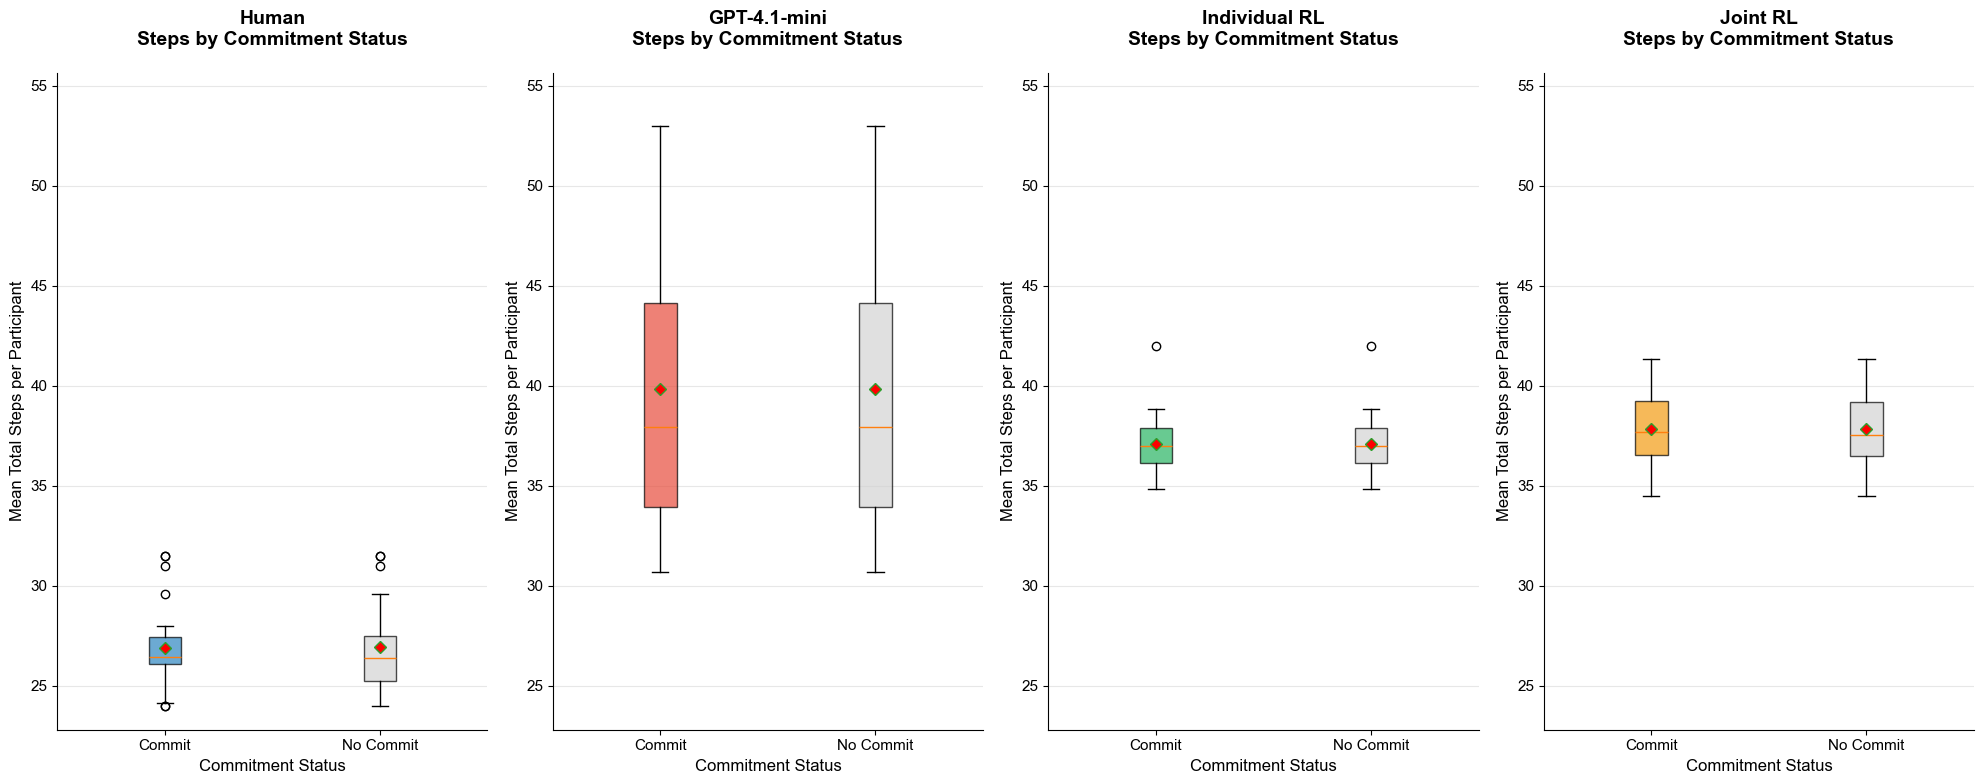


=== OVERALL COMMITMENT-STEPS SUMMARY ===
Overall Commit: M = 34.72 ± 5.94, N = 108
Overall No Commit: M = 35.42 ± 5.72, N = 95
Overall t-test: t = -0.859, p = 0.391
✅ Steps by commitment status analysis complete!


In [ ]:
# Total Steps by Commitment Status Analysis
if 'merged_steps_data' in locals() and not merged_steps_data.empty and 'merged_commitment_data' in locals() and not merged_commitment_data.empty:
    print("=== TOTAL STEPS BY COMMITMENT STATUS ANALYSIS ===")

    # Merge steps data with commitment data to get commitment status for each trial
    steps_commitment_merged = merged_steps_data.merge(
        merged_commitment_data[['participant_id', 'game_type', 'study', 'human_commitment']],
        on=['participant_id', 'game_type', 'study'],
        how='inner'
    )

    if len(steps_commitment_merged) > 0:
        # Create commitment status labels
        steps_commitment_merged['commitment_status'] = steps_commitment_merged['human_commitment'].map({
            1: 'Commit',
            0: 'No Commit'
        })

        # Calculate participant-level means by commitment status
        participant_steps_commitment = steps_commitment_merged.groupby(
            ['participant_id', 'game_type', 'study', 'commitment_status']
        )['total_steps'].mean().reset_index()
        participant_steps_commitment.rename(columns={'total_steps': 'mean_steps'}, inplace=True)

        # Filter to available game types
        available_commit_types = [gt for gt in ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
                                 if gt in participant_steps_commitment['game_type'].values]
        available_commit_labels = [{'human': 'Human', 'gpt-4.1-mini': 'GPT-4.1-mini',
                                   'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}[gt]
                                  for gt in available_commit_types]
        available_commit_colors = [CONDITION_COLORS[gt] for gt in available_commit_types]

        print(f"Available game types for commitment analysis: {available_commit_types}")
        print(f"Total participant-commitment combinations: {len(participant_steps_commitment)}")

        # Calculate global y-axis range for consistent scaling
        all_steps_data = participant_steps_commitment['mean_steps']
        y_min = all_steps_data.min() * 0.95
        y_max = all_steps_data.max() * 1.05

        # Create visualization
        fig, axes = plt.subplots(1, len(available_commit_types), figsize=(5 * len(available_commit_types), 8))
        if len(available_commit_types) == 1:
            axes = [axes]

        for i, game_type in enumerate(available_commit_types):
            ax = axes[i]
            game_label = available_commit_labels[i]
            game_color = available_commit_colors[i]

            # Filter data for this game type
            game_data = participant_steps_commitment[
                participant_steps_commitment['game_type'] == game_type
            ]

            if len(game_data) > 0:
                # Separate commit and no-commit data
                commit_data = game_data[game_data['commitment_status'] == 'Commit']['mean_steps']
                no_commit_data = game_data[game_data['commitment_status'] == 'No Commit']['mean_steps']

                # Create box plots
                box_data = []
                box_labels = []
                box_colors = []

                if len(commit_data) > 0:
                    box_data.append(commit_data.values)
                    box_labels.append('Commit')
                    box_colors.append(game_color)

                if len(no_commit_data) > 0:
                    box_data.append(no_commit_data.values)
                    box_labels.append('No Commit')
                    box_colors.append('lightgray')

                if box_data:
                    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                                   showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red'})

                    # Color the boxes
                    for patch, color in zip(bp['boxes'], box_colors):
                        patch.set_facecolor(color)
                        patch.set_alpha(0.7)

                ax.set_title(f'{game_label}\nSteps by Commitment Status', fontweight='bold', pad=20)
                ax.set_ylabel('Mean Total Steps per Participant')
                ax.set_xlabel('Commitment Status')
                ax.set_ylim(y_min, y_max)  # Set consistent y-axis range
                ax.grid(True, alpha=0.3, axis='y')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                # Print statistics for this game type
                print(f"\n{game_label} Statistics:")
                if len(commit_data) > 0:
                    print(f"  Commit: M = {commit_data.mean():.2f} ± {commit_data.std():.2f}, N = {len(commit_data)}")
                if len(no_commit_data) > 0:
                    print(f"  No Commit: M = {no_commit_data.mean():.2f} ± {no_commit_data.std():.2f}, N = {len(no_commit_data)}")

                # Statistical test if both groups have data
                if len(commit_data) > 1 and len(no_commit_data) > 1:
                    t_stat, p_val = stats.ttest_ind(commit_data, no_commit_data)
                    print(f"  t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

        plt.tight_layout()
        plt.savefig('merged_steps_by_commitment_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Overall summary statistics
        print(f"\n=== OVERALL COMMITMENT-STEPS SUMMARY ===")
        overall_commit = participant_steps_commitment[participant_steps_commitment['commitment_status'] == 'Commit']['mean_steps']
        overall_no_commit = participant_steps_commitment[participant_steps_commitment['commitment_status'] == 'No Commit']['mean_steps']

        if len(overall_commit) > 0:
            print(f"Overall Commit: M = {overall_commit.mean():.2f} ± {overall_commit.std():.2f}, N = {len(overall_commit)}")
        if len(overall_no_commit) > 0:
            print(f"Overall No Commit: M = {overall_no_commit.mean():.2f} ± {overall_no_commit.std():.2f}, N = {len(overall_no_commit)}")

        if len(overall_commit) > 1 and len(overall_no_commit) > 1:
            t_stat, p_val = stats.ttest_ind(overall_commit, overall_no_commit)
            print(f"Overall t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

        print("✅ Steps by commitment status analysis complete!")

    else:
        print("❌ No merged steps-commitment data available")
else:
    print("❌ Steps or commitment data not available. Run previous cells first.")


## Step 11: Merged AI Detection Analysis

Analysis of how participants perceived their partner on the human-like to AI-like spectrum across all four game types.

=== MERGED AI DETECTION ANALYSIS ===


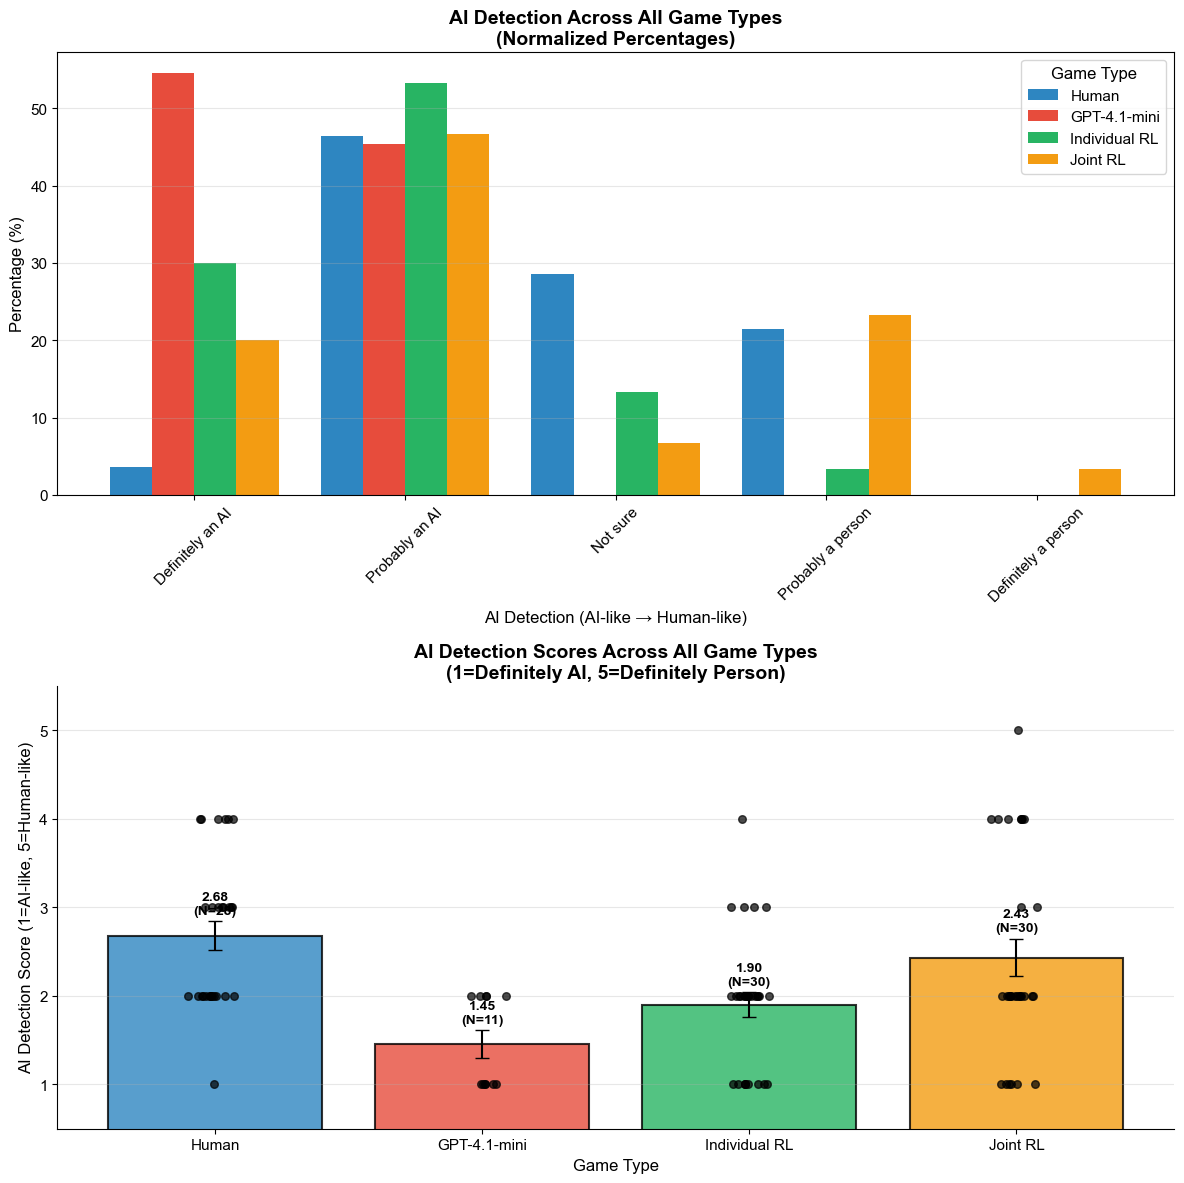


=== AI DETECTION SUMMARY BY GAME TYPE ===

Human (n=28):
  Human-like: 6 (21.4%)
  Not sure: 8 (28.6%)
  AI-like: 14 (50.0%)

GPT-4.1-mini (n=11):
  Human-like: 0 (0.0%)
  Not sure: 0 (0.0%)
  AI-like: 11 (100.0%)

Individual RL (n=30):
  Human-like: 1 (3.3%)
  Not sure: 4 (13.3%)
  AI-like: 25 (83.3%)

Joint RL (n=30):
  Human-like: 8 (26.7%)
  Not sure: 2 (6.7%)
  AI-like: 20 (66.7%)


In [110]:
# AI Detection Analysis Across All Game Types
if 'merged_questionnaire_df' in locals() and not merged_questionnaire_df.empty:
    print("=== MERGED AI DETECTION ANALYSIS ===")

    # Prepare data for analysis using the same game_type_order as collaboration analysis
    quest_game_types = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    quest_game_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
    quest_colors = [CONDITION_COLORS[gt] for gt in quest_game_types]

    # Filter data to available game types
    available_quest_data = merged_questionnaire_df[
        merged_questionnaire_df['game_type'].isin(quest_game_types)
    ].copy()

    if len(available_quest_data) > 0:
        # Determine available types
        available_types = [gt for gt in quest_game_types if gt in available_quest_data['game_type'].values]
        available_labels = [quest_game_labels[quest_game_types.index(gt)] for gt in available_types]
        available_colors = [quest_colors[quest_game_types.index(gt)] for gt in available_types]

        # Create visualization with two plots: percentages and scores
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

        # Prepare data for plotting
        ai_detection_data = available_quest_data.groupby(['game_type', 'ai_detection_cat'], observed=True).size().unstack(fill_value=0)

        # Reorder to match our game type order
        ai_detection_data_ordered = ai_detection_data.loc[available_types]

        # Plot 1: Normalized percentages - FIXED: Reverse the order to go from AI-like to Human-like
        ai_detection_norm = ai_detection_data_ordered.div(ai_detection_data_ordered.sum(axis=1), axis=0) * 100
        ai_detection_norm_reversed = ai_detection_norm.T.iloc[::-1]
        ai_detection_norm_reversed.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)
        ax1.set_title('AI Detection Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
        ax1.set_xlabel('AI Detection (AI-like → Human-like)', fontsize=12)
        ax1.set_ylabel('Percentage (%)', fontsize=12)
        ax1.legend(available_labels, title='Game Type', title_fontsize=12)
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(axis='y', alpha=0.3)

        # Plot 2: Score-based analysis
        # Convert AI detection responses to numerical scores (1=Definitely AI, 5=Definitely Person)
        ai_detection_score_mapping = {
            'Definitely an AI': 1,
            'Probably an AI': 2,
            'Not sure': 3,
            'Probably a person': 4,
            'Definitely a person': 5
        }

        available_quest_data['ai_detection_score'] = available_quest_data['ai_detection'].map(ai_detection_score_mapping)

        # Calculate mean scores and standard errors for each game type
        score_data = []
        score_errors = []
        for game_type in available_types:
            subset = available_quest_data[available_quest_data['game_type'] == game_type]
            scores = subset['ai_detection_score'].dropna()
            if len(scores) > 0:
                mean_score = scores.mean()
                se_score = scores.std() / np.sqrt(len(scores))
                score_data.append(mean_score)
                score_errors.append(se_score)
            else:
                score_data.append(0)
                score_errors.append(0)

        # Create bar plot for scores
        bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                       alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

        # Add individual data points with jitter
        for i, game_type in enumerate(available_types):
            subset = available_quest_data[available_quest_data['game_type'] == game_type]
            scores = subset['ai_detection_score'].dropna()
            if len(scores) > 0:
                x_positions = np.random.normal(i, 0.04, size=len(scores))
                ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

        # Add value labels on bars
        for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
            n = len(available_quest_data[available_quest_data['game_type'] == available_types[i]]['ai_detection_score'].dropna())
            ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                    f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax2.set_title('AI Detection Scores Across All Game Types\n(1=Definitely AI, 5=Definitely Person)', fontweight='bold', fontsize=14)
        ax2.set_xlabel('Game Type', fontsize=12)
        ax2.set_ylabel('AI Detection Score (1=AI-like, 5=Human-like)', fontsize=12)
        ax2.set_ylim(0.5, 5.5)
        ax2.grid(axis='y', alpha=0.3)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('merged_ai_detection_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print summary statistics
        print("\n=== AI DETECTION SUMMARY BY GAME TYPE ===")
        for game_type in available_types:
            subset = available_quest_data[available_quest_data['game_type'] == game_type]
            label = quest_game_labels[quest_game_types.index(game_type)]
            print(f"\n{label} (n={len(subset)}):")

            # Calculate Human-like vs AI-like percentages (corrected based on source code)
            human_like = len(subset[subset['ai_detection'].isin(['Definitely a person', 'Probably a person'])])
            ai_like = len(subset[subset['ai_detection'].isin(['Definitely an AI', 'Probably an AI'])])
            not_sure = len(subset[subset['ai_detection'] == 'Not sure'])

            total = len(subset)
            print(f"  Human-like: {human_like} ({human_like/total*100:.1f}%)")
            print(f"  Not sure: {not_sure} ({not_sure/total*100:.1f}%)")
            print(f"  AI-like: {ai_like} ({ai_like/total*100:.1f}%)")

        # Store variables for later use
        globals()['available_types'] = available_types
        globals()['available_labels'] = available_labels
        globals()['available_colors'] = available_colors
        globals()['available_quest_data'] = available_quest_data

    else:
        print("No questionnaire data available for AI detection analysis")
else:
    print("Questionnaire data will be available after running cell 16 and 18 (load and standardize questionnaire data)")

## Step 12: Merged Collaboration Rating Analysis

Analysis of how participants rated their partner as a collaborator across all four game types.

=== MERGED COLLABORATION RATING ANALYSIS ===


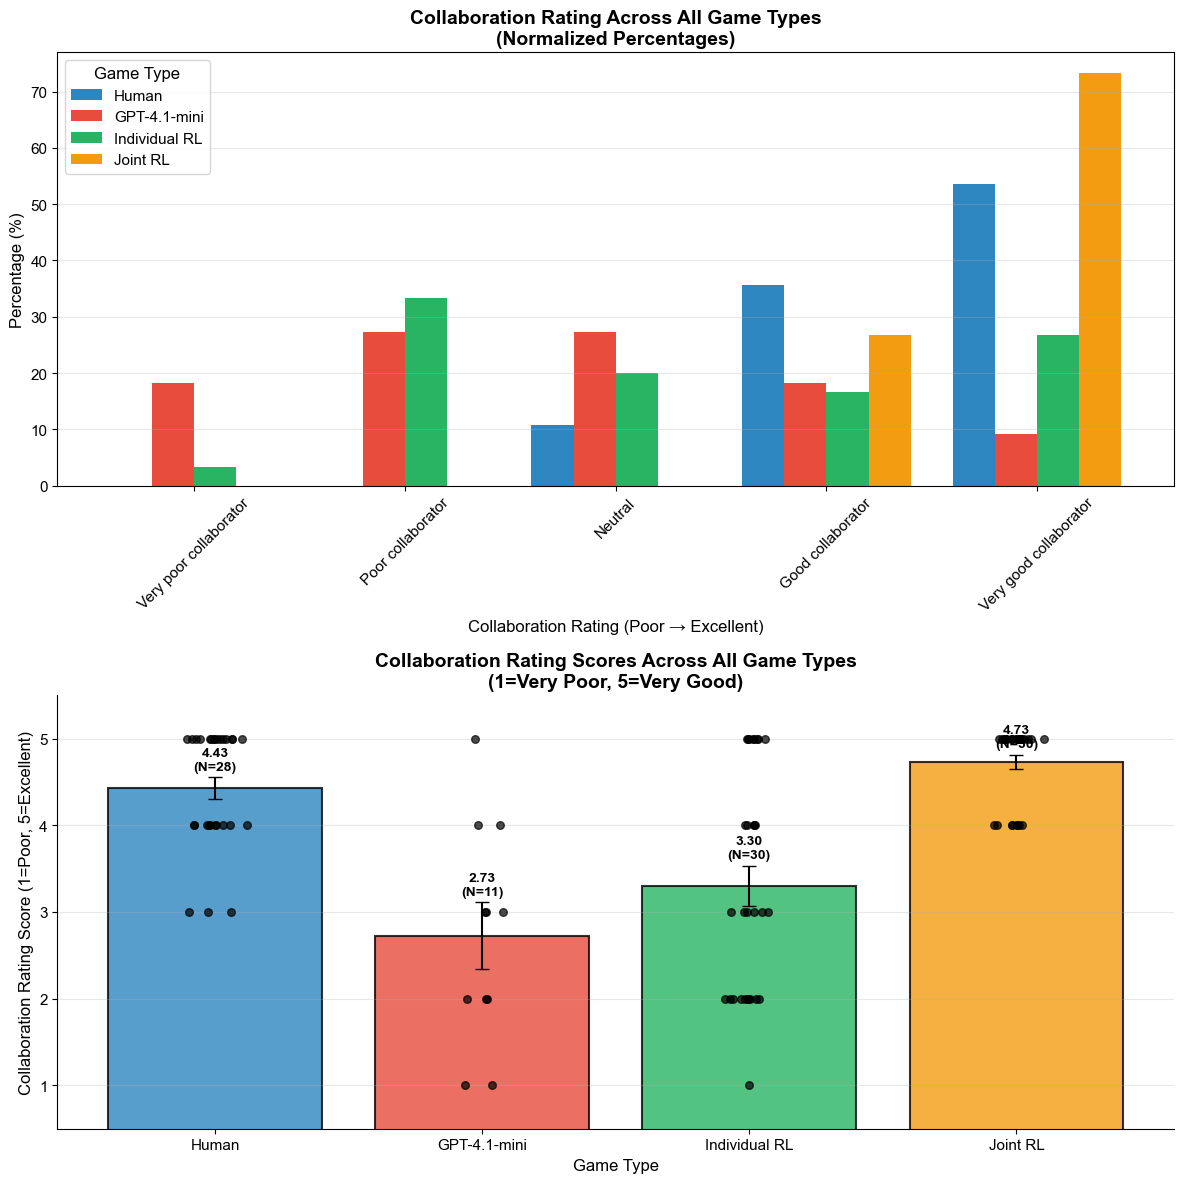


=== COLLABORATION RATING SUMMARY BY GAME TYPE ===

Human (n=28):
  Good/Very Good: 25 (89.3%)
  Neutral: 3 (10.7%)
  Poor/Very Poor: 0 (0.0%)

GPT-4.1-mini (n=11):
  Good/Very Good: 3 (27.3%)
  Neutral: 3 (27.3%)
  Poor/Very Poor: 5 (45.5%)

Individual RL (n=30):
  Good/Very Good: 13 (43.3%)
  Neutral: 6 (20.0%)
  Poor/Very Poor: 11 (36.7%)

Joint RL (n=30):
  Good/Very Good: 30 (100.0%)
  Neutral: 0 (0.0%)
  Poor/Very Poor: 0 (0.0%)


In [111]:
# Collaboration Rating Analysis Across All Game Types
if 'merged_questionnaire_df' in locals() and not merged_questionnaire_df.empty and 'available_quest_data' in locals() and len(available_quest_data) > 0:
    print("=== MERGED COLLABORATION RATING ANALYSIS ===")

    # Create visualization with two plots: percentages and scores
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Prepare data for plotting
    collab_rating_data = available_quest_data.groupby(['game_type', 'collaboration_rating_cat'], observed=True).size().unstack(fill_value=0)
    collab_rating_data_ordered = collab_rating_data.loc[available_types]

    # Plot 1: Normalized percentages
    collab_rating_norm = collab_rating_data_ordered.div(collab_rating_data_ordered.sum(axis=1), axis=0) * 100
    collab_rating_norm.T.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)
    ax1.set_title('Collaboration Rating Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Collaboration Rating (Poor → Excellent)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Score-based analysis
    # Convert collaboration rating responses to numerical scores (1=Very Poor, 5=Very Good)
    collab_rating_score_mapping = {
        'Very poor collaborator': 1,
        'Poor collaborator': 2,
        'Neutral': 3,
        'Good collaborator': 4,
        'Very good collaborator': 5
    }

    available_quest_data['collaboration_rating_score'] = available_quest_data['collaboration_rating'].map(collab_rating_score_mapping)

    # Calculate mean scores and standard errors for each game type
    score_data = []
    score_errors = []
    for game_type in available_types:
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        scores = subset['collaboration_rating_score'].dropna()
        if len(scores) > 0:
            mean_score = scores.mean()
            se_score = scores.std() / np.sqrt(len(scores))
            score_data.append(mean_score)
            score_errors.append(se_score)
        else:
            score_data.append(0)
            score_errors.append(0)

    # Create bar plot for scores
    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    # Add individual data points with jitter
    for i, game_type in enumerate(available_types):
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        scores = subset['collaboration_rating_score'].dropna()
        if len(scores) > 0:
            x_positions = np.random.normal(i, 0.04, size=len(scores))
            ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    # Add value labels on bars
    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(available_quest_data[available_quest_data['game_type'] == available_types[i]]['collaboration_rating_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('Collaboration Rating Scores Across All Game Types\n(1=Very Poor, 5=Very Good)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('Collaboration Rating Score (1=Poor, 5=Excellent)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_collaboration_rating_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n=== COLLABORATION RATING SUMMARY BY GAME TYPE ===")
    for game_type in available_types:
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        label = quest_game_labels[quest_game_types.index(game_type)]
        print(f"\n{label} (n={len(subset)}):")

        # Calculate good vs poor collaboration percentages
        good_collab = len(subset[subset['collaboration_rating'].isin(['Good collaborator', 'Very good collaborator'])])
        poor_collab = len(subset[subset['collaboration_rating'].isin(['Poor collaborator', 'Very poor collaborator'])])
        neutral = len(subset[subset['collaboration_rating'] == 'Neutral'])

        total = len(subset)
        print(f"  Good/Very Good: {good_collab} ({good_collab/total*100:.1f}%)")
        print(f"  Neutral: {neutral} ({neutral/total*100:.1f}%)")
        print(f"  Poor/Very Poor: {poor_collab} ({poor_collab/total*100:.1f}%)")
else:
    print("Collaboration rating data will be available after running questionnaire loading and standardization cells")

## Step 13: Merged Play Again Intention Analysis

Analysis of participants' willingness to play with the same partner again across all four game types.

=== MERGED PLAY AGAIN INTENTION ANALYSIS ===


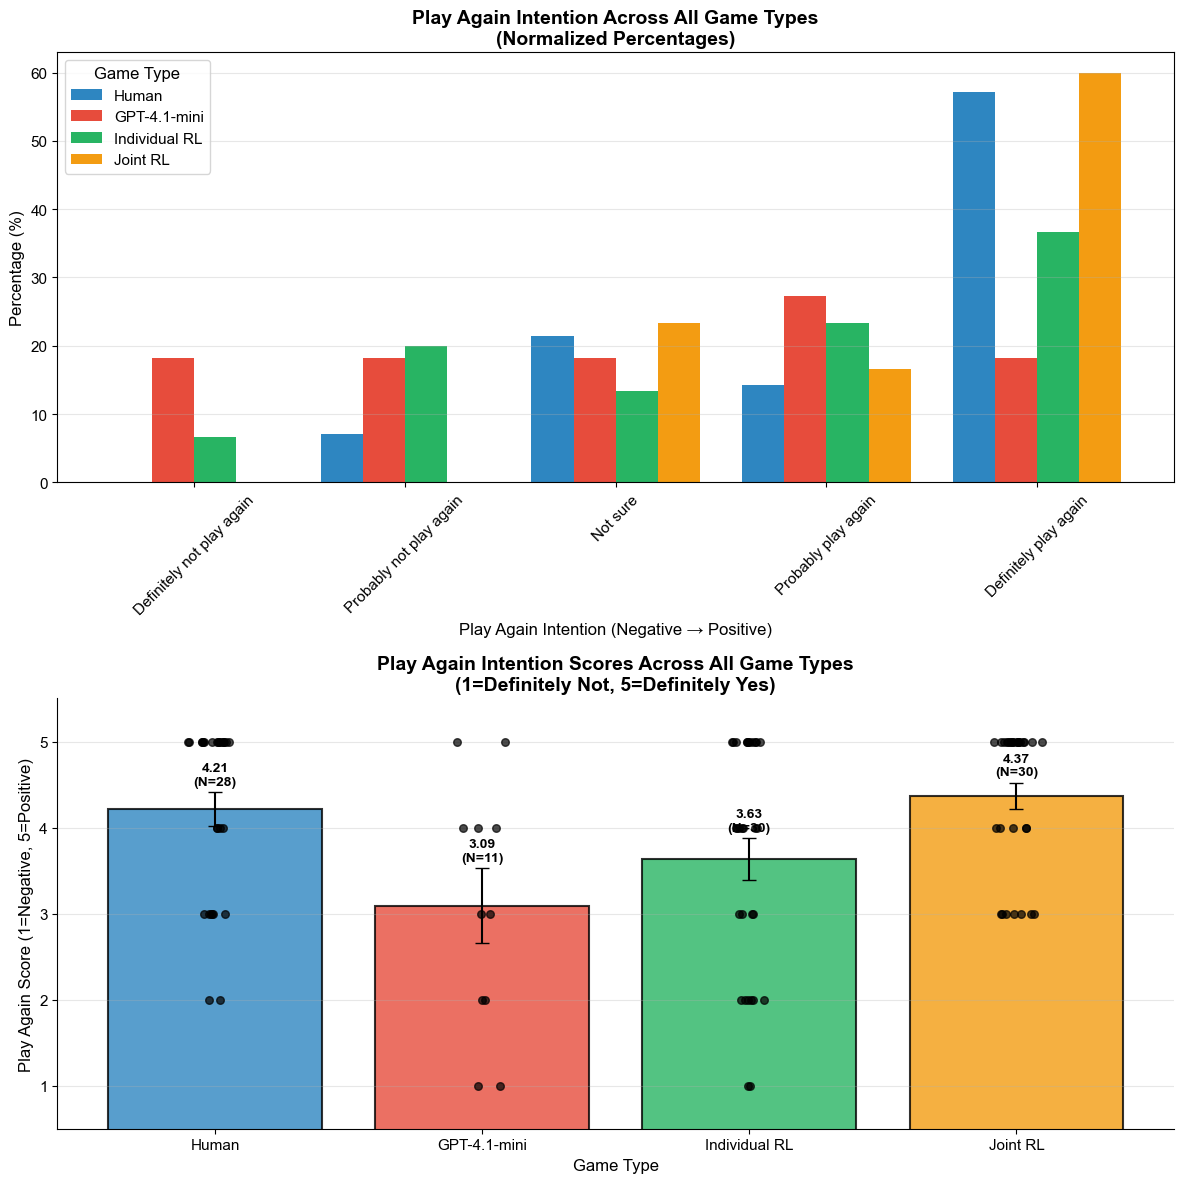


=== PLAY AGAIN INTENTION SUMMARY BY GAME TYPE ===

Human (n=28):
  Positive: 20 (71.4%)
  Not sure: 6 (21.4%)
  Negative: 2 (7.1%)

GPT-4.1-mini (n=11):
  Positive: 5 (45.5%)
  Not sure: 2 (18.2%)
  Negative: 4 (36.4%)

Individual RL (n=30):
  Positive: 18 (60.0%)
  Not sure: 4 (13.3%)
  Negative: 8 (26.7%)

Joint RL (n=30):
  Positive: 23 (76.7%)
  Not sure: 7 (23.3%)
  Negative: 0 (0.0%)


In [112]:
# Play Again Intention Analysis Across All Game Types
if 'merged_questionnaire_df' in locals() and not merged_questionnaire_df.empty and 'available_quest_data' in locals() and len(available_quest_data) > 0:
    print("=== MERGED PLAY AGAIN INTENTION ANALYSIS ===")

    # Create visualization with two plots: percentages and scores
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Prepare data for plotting
    play_again_data = available_quest_data.groupby(['game_type', 'play_again_cat'], observed=True).size().unstack(fill_value=0)
    play_again_data_ordered = play_again_data.loc[available_types]

    # Plot 1: Normalized percentages
    play_again_norm = play_again_data_ordered.div(play_again_data_ordered.sum(axis=1), axis=0) * 100
    play_again_norm.T.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)
    ax1.set_title('Play Again Intention Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Play Again Intention (Negative → Positive)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Score-based analysis
    # Convert play again responses to numerical scores (1=Definitely Not, 5=Definitely Yes)
    play_again_score_mapping = {
        'Definitely not play again': 1,
        'Probably not play again': 2,
        'Not sure': 3,
        'Probably play again': 4,
        'Definitely play again': 5
    }

    available_quest_data['play_again_score'] = available_quest_data['play_again'].map(play_again_score_mapping)

    # Calculate mean scores and standard errors for each game type
    score_data = []
    score_errors = []
    for game_type in available_types:
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        scores = subset['play_again_score'].dropna()
        if len(scores) > 0:
            mean_score = scores.mean()
            se_score = scores.std() / np.sqrt(len(scores))
            score_data.append(mean_score)
            score_errors.append(se_score)
        else:
            score_data.append(0)
            score_errors.append(0)

    # Create bar plot for scores
    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    # Add individual data points with jitter
    for i, game_type in enumerate(available_types):
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        scores = subset['play_again_score'].dropna()
        if len(scores) > 0:
            x_positions = np.random.normal(i, 0.04, size=len(scores))
            ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    # Add value labels on bars
    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(available_quest_data[available_quest_data['game_type'] == available_types[i]]['play_again_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('Play Again Intention Scores Across All Game Types\n(1=Definitely Not, 5=Definitely Yes)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('Play Again Score (1=Negative, 5=Positive)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_play_again_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n=== PLAY AGAIN INTENTION SUMMARY BY GAME TYPE ===")
    for game_type in available_types:
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        label = quest_game_labels[quest_game_types.index(game_type)]
        print(f"\n{label} (n={len(subset)}):")

        # Calculate positive vs negative intention percentages
        positive = len(subset[subset['play_again'].isin(['Definitely play again', 'Probably play again'])])
        negative = len(subset[subset['play_again'].isin(['Definitely not play again', 'Probably not play again'])])
        not_sure = len(subset[subset['play_again'] == 'Not sure'])

        total = len(subset)
        print(f"  Positive: {positive} ({positive/total*100:.1f}%)")
        print(f"  Not sure: {not_sure} ({not_sure/total*100:.1f}%)")
        print(f"  Negative: {negative} ({negative/total*100:.1f}%)")
else:
    print("Play again data will be available after running questionnaire loading and standardization cells")

## Step 14: Comprehensive Questionnaire Summary and Final Results

In [113]:
# Comprehensive Questionnaire Summary and Final Results
if 'merged_questionnaire_df' in locals() and not merged_questionnaire_df.empty and 'available_quest_data' in locals() and len(available_quest_data) > 0:
    print("🎯 === COMPREHENSIVE MERGED QUESTIONNAIRE ANALYSIS SUMMARY === 🎯")
    print(f"Total questionnaire responses analyzed: {len(available_quest_data)}")

    # Sample distribution
    print(f"\n📊 Sample Distribution by Game Type:")
    for game_type in available_types:
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        label = quest_game_labels[quest_game_types.index(game_type)]
        count = len(subset)
        percentage = (count / len(available_quest_data)) * 100
        print(f"  {label}: {count} responses ({percentage:.1f}%)")

    print(f"\n📊 Sample Distribution by Study:")
    study_dist = available_quest_data['study'].value_counts()
    for study, count in study_dist.items():
        percentage = (count / len(available_quest_data)) * 100
        print(f"  {study}: {count} responses ({percentage:.1f}%)")

    # Create comprehensive summary table
    summary_data = []

    print(f"\n🔍 === KEY FINDINGS BY GAME TYPE ===")

    for game_type in available_types:
        subset = available_quest_data[available_quest_data['game_type'] == game_type]
        label = quest_game_labels[quest_game_types.index(game_type)]
        n = len(subset)

        print(f"\n{label} (N={n}):")

        # AI Detection (corrected based on source code mappings)
        ai_like_count = len(subset[subset['ai_detection'].isin(['Definitely an AI', 'Probably an AI'])])
        ai_like_pct = (ai_like_count / n) * 100 if n > 0 else 0
        print(f"  🤖 AI Detection: {ai_like_count}/{n} ({ai_like_pct:.1f}%) perceived as AI-like")

        # Collaboration Rating
        good_collab_count = len(subset[subset['collaboration_rating'].isin(['Good collaborator', 'Very good collaborator'])])
        good_collab_pct = (good_collab_count / n) * 100 if n > 0 else 0
        print(f"  🤝 Collaboration: {good_collab_count}/{n} ({good_collab_pct:.1f}%) rated as good/very good collaborator")

        # Play Again
        positive_count = len(subset[subset['play_again'].isin(['Definitely play again', 'Probably play again'])])
        positive_pct = (positive_count / n) * 100 if n > 0 else 0
        print(f"  🎮 Play Again: {positive_count}/{n} ({positive_pct:.1f}%) would play again")

        summary_data.append({
            'Game_Type': label,
            'N': n,
            'AI_Like_Count': ai_like_count,
            'AI_Like_Percent': f"{ai_like_pct:.1f}%",
            'Good_Collab_Count': good_collab_count,
            'Good_Collab_Percent': f"{good_collab_pct:.1f}%",
            'Positive_Play_Count': positive_count,
            'Positive_Play_Percent': f"{positive_pct:.1f}%",
            'Study': subset['study'].iloc[0] if n > 0 else ''
        })

    # Statistical tests summary
    print(f"\n📈 === STATISTICAL TESTS SUMMARY ===")

    statistical_results = []

    # Test 1: AI Detection
    if len(available_types) >= 2:
        contingency_ai = pd.crosstab(available_quest_data['game_type'], available_quest_data['ai_detection'])
        chi2_ai, p_value_ai, dof_ai, expected_ai = chi2_contingency(contingency_ai)
        sig_ai = "***" if p_value_ai < 0.001 else "**" if p_value_ai < 0.01 else "*" if p_value_ai < 0.05 else "ns"

        print(f"🤖 AI Detection: χ² = {chi2_ai:.3f}, p = {p_value_ai:.3f} {sig_ai}")

        statistical_results.append({
            'Variable': 'AI Detection',
            'Chi2_Statistic': f"{chi2_ai:.3f}",
            'P_Value': f"{p_value_ai:.3f}",
            'Significance': sig_ai,
            'Significant': p_value_ai < 0.05
        })

        # Test 2: Collaboration Rating
        contingency_collab = pd.crosstab(available_quest_data['game_type'], available_quest_data['collaboration_rating'])
        chi2_collab, p_value_collab, dof_collab, expected_collab = chi2_contingency(contingency_collab)
        sig_collab = "***" if p_value_collab < 0.001 else "**" if p_value_collab < 0.01 else "*" if p_value_collab < 0.05 else "ns"

        print(f"🤝 Collaboration Rating: χ² = {chi2_collab:.3f}, p = {p_value_collab:.3f} {sig_collab}")

        statistical_results.append({
            'Variable': 'Collaboration Rating',
            'Chi2_Statistic': f"{chi2_collab:.3f}",
            'P_Value': f"{p_value_collab:.3f}",
            'Significance': sig_collab,
            'Significant': p_value_collab < 0.05
        })

        # Test 3: Play Again Intention
        contingency_play = pd.crosstab(available_quest_data['game_type'], available_quest_data['play_again'])
        chi2_play, p_value_play, dof_play, expected_play = chi2_contingency(contingency_play)
        sig_play = "***" if p_value_play < 0.001 else "**" if p_value_play < 0.01 else "*" if p_value_play < 0.05 else "ns"

        print(f"🎮 Play Again Intention: χ² = {chi2_play:.3f}, p = {p_value_play:.3f} {sig_play}")

        statistical_results.append({
            'Variable': 'Play Again Intention',
            'Chi2_Statistic': f"{chi2_play:.3f}",
            'P_Value': f"{p_value_play:.3f}",
            'Significance': sig_play,
            'Significant': p_value_play < 0.05
        })

    # Summary of significant findings
    significant_vars = [result['Variable'] for result in statistical_results if result['Significant']]

    print(f"\n🎯 === OVERALL QUESTIONNAIRE FINDINGS ===")
    if significant_vars:
        print(f"✅ Significant differences found in: {', '.join(significant_vars)}")
        print(f"🔑 Partner type significantly affects user perceptions and satisfaction!")
    else:
        print(f"❌ No significant differences found across game types")

    # Save comprehensive results
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('merged_questionnaire_summary_by_game_type.csv', index=False)

    if statistical_results:
        stats_df = pd.DataFrame(statistical_results)
        stats_df.to_csv('merged_questionnaire_statistical_tests.csv', index=False)

    # Save detailed questionnaire data
    available_quest_data.to_csv('merged_questionnaire_detailed_responses.csv', index=False)

    print(f"\n💾 Questionnaire Analysis Results Saved:")
    print(f"   - merged_questionnaire_summary_by_game_type.csv")
    print(f"   - merged_questionnaire_statistical_tests.csv")
    print(f"   - merged_questionnaire_detailed_responses.csv")
    print(f"   - merged_ai_detection_analysis.png")
    print(f"   - merged_collaboration_rating_analysis.png")
    print(f"   - merged_play_again_analysis.png")

    # Display summary table
    print(f"\n📊 Summary Table:")
    print(summary_df.to_string(index=False))

    if statistical_results:
        print(f"\n📈 Statistical Tests Summary:")
        print(stats_df.to_string(index=False))

    print(f"\n🎉 Merged questionnaire analysis complete!")
    print(f"Total participants analyzed across both studies: {len(available_quest_data)}")
    print(f"✅ Using correct questionnaire mappings from TimelineManager.js source code")

else:
    print("Comprehensive questionnaire summary will be available after running questionnaire loading and analysis cells")

🎯 === COMPREHENSIVE MERGED QUESTIONNAIRE ANALYSIS SUMMARY === 🎯
Total questionnaire responses analyzed: 99

📊 Sample Distribution by Game Type:
  Human: 28 responses (28.3%)
  GPT-4.1-mini: 11 responses (11.1%)
  Individual RL: 30 responses (30.3%)
  Joint RL: 30 responses (30.3%)

📊 Sample Distribution by Study:
  Human-RL: 60 responses (60.6%)
  Human-Human-GPT: 39 responses (39.4%)

🔍 === KEY FINDINGS BY GAME TYPE ===

Human (N=28):
  🤖 AI Detection: 14/28 (50.0%) perceived as AI-like
  🤝 Collaboration: 25/28 (89.3%) rated as good/very good collaborator
  🎮 Play Again: 20/28 (71.4%) would play again

GPT-4.1-mini (N=11):
  🤖 AI Detection: 11/11 (100.0%) perceived as AI-like
  🤝 Collaboration: 3/11 (27.3%) rated as good/very good collaborator
  🎮 Play Again: 5/11 (45.5%) would play again

Individual RL (N=30):
  🤖 AI Detection: 25/30 (83.3%) perceived as AI-like
  🤝 Collaboration: 13/30 (43.3%) rated as good/very good collaborator
  🎮 Play Again: 18/30 (60.0%) would play again

Joint

# Commitment Analysis: 2P3G Across All Four Game Types

This section analyzes commitment patterns in 2P3G experiments across all four game types:
- **Human**: Pure human-human collaboration 
- **GPT-4.1-mini**: Human-GPT collaboration
- **Individual RL**: Human collaborating with individually-trained RL agent
- **Joint RL**: Human collaborating with jointly-trained RL agent

**Commitment Definition**: Whether the first detected shared goal (`firstDetectedSharedGoal`) matches the final reached goal.

For human-human-gpt games: Uses correct player indexing based on `humanPlayerIndex` (human player 0 or 1)
For human-rl games: Uses human as player 1 consistently (since human player is always index 0)

In [114]:
print("=== COMMITMENT ANALYSIS: 2P3G ACROSS ALL FOUR GAME TYPES ===")

print("✅ Commitment calculation functions defined in cell 3 with correct player indexing")
print("✅ Distance condition renaming functions defined in cell 3")
print("✅ Ready to load and process 2P3G commitment data across all game types")

=== COMMITMENT ANALYSIS: 2P3G ACROSS ALL FOUR GAME TYPES ===
✅ Commitment calculation functions defined in cell 3 with correct player indexing
✅ Distance condition renaming functions defined in cell 3
✅ Ready to load and process 2P3G commitment data across all game types


In [115]:
# Load and process 2P3G trial-level data for commitment analysis
print("=== LOADING 2P3G TRIAL DATA FOR COMMITMENT ANALYSIS ===")

# Load Human-RL 2P3G trial data
rl_commitment_data = []
rl_files = glob.glob('human-RLs/data-original/*.xlsx')

print(f"\nLoading Human-RL 2P3G trial data from {len(rl_files)} files...")

for file in rl_files:
    try:
        excel_file = pd.ExcelFile(file)
        if 'Experiment Data' in excel_file.sheet_names:
            exp_df = pd.read_excel(file, sheet_name='Experiment Data')
            exp_df['file_id'] = os.path.basename(file)
            exp_df['study'] = 'Human-RL'

            # Filter for 2P3G trials only
            exp_2p3g = exp_df[exp_df['experimentType'] == '2P3G'].copy()

            if len(exp_2p3g) > 0:
                # Map RL agent type to our game type classification
                exp_2p3g['game_type'] = exp_2p3g['rlAgentType'].map({
                    'individual': 'individual_rl',
                    'joint': 'joint_rl'
                })

                # Rename distance conditions for Human-RL data
                exp_2p3g['distanceCondition_renamed'] = exp_2p3g.apply(
                    lambda row: rename_distance_condition_human_ai(row, 'Human-RL'), axis=1
                )

                # Calculate commitment for Human-RL data
                exp_2p3g['human_commitment'] = exp_2p3g.apply(
                    lambda row: calculate_human_commitment_2p3g_merged(row, 'Human-RL'), axis=1
                )

                rl_commitment_data.append(exp_2p3g)
    except Exception as e:
        print(f"Error loading RL commitment data from {file}: {e}")

# Combine RL commitment data
if rl_commitment_data:
    rl_combined_commitment = pd.concat(rl_commitment_data, ignore_index=True)
    print(f"Human-RL 2P3G commitment data: {len(rl_combined_commitment)} trials")
    print(f"Game types: {rl_combined_commitment['game_type'].value_counts()}")

    # Show renamed distance conditions for RL
    if 'distanceCondition_renamed' in rl_combined_commitment.columns:
        print(f"RL Renamed distance conditions:")
        print(rl_combined_commitment['distanceCondition_renamed'].value_counts())
else:
    rl_combined_commitment = pd.DataFrame()
    print("No Human-RL 2P3G commitment data found")

# Load Human-Human-GPT 2P3G trial data
hh_gpt_commitment_data = []
hh_gpt_files = glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx')

print(f"\nLoading Human-Human-GPT 2P3G trial data from {len(hh_gpt_files)} files...")

# Load classification data for game types
try:
    classification_df = pd.read_csv('human-human-with-gpt-fallback/file_classification_summary.csv')
    print(f"Loaded game type classifications for {len(classification_df)} files")
except Exception as e:
    print(f"Error loading classification data: {e}")
    classification_df = pd.DataFrame()

for file in hh_gpt_files:
    try:
        excel_file = pd.ExcelFile(file)
        if 'ExperimentData' in excel_file.sheet_names:
            exp_df = pd.read_excel(file, sheet_name='ExperimentData')
            exp_df['file_id'] = os.path.basename(file)
            exp_df['study'] = 'Human-Human-GPT'

            # Filter for 2P3G trials only
            exp_2p3g = exp_df[exp_df['experimentType'] == '2P3G'].copy()

            if len(exp_2p3g) > 0:
                # Rename distance conditions for Human-Human-GPT data
                exp_2p3g['distanceCondition_renamed'] = exp_2p3g.apply(
                    lambda row: rename_distance_condition_human_ai(row, 'Human-Human-GPT'), axis=1
                )

                # Calculate commitment for Human-Human-GPT data
                exp_2p3g['human_commitment'] = exp_2p3g.apply(
                    lambda row: calculate_human_commitment_2p3g_merged(row, 'Human-Human-GPT'), axis=1
                )

                hh_gpt_commitment_data.append(exp_2p3g)
    except Exception as e:
        print(f"Error loading HH-GPT commitment data from {file}: {e}")

# Combine HH-GPT commitment data and merge with game type classification
if hh_gpt_commitment_data:
    hh_gpt_combined_commitment = pd.concat(hh_gpt_commitment_data, ignore_index=True)

    # Merge with game type classification
    if not classification_df.empty:
        hh_gpt_combined_commitment = hh_gpt_combined_commitment.merge(
            classification_df[['file_name', 'game_type']],
            left_on='file_id',
            right_on='file_name',
            how='left'
        )

    print(f"Human-Human-GPT 2P3G commitment data: {len(hh_gpt_combined_commitment)} trials")
    print(f"Game types: {hh_gpt_combined_commitment['game_type'].value_counts()}")

    # Show renamed distance conditions for HH-GPT
    if 'distanceCondition_renamed' in hh_gpt_combined_commitment.columns:
        print(f"HH-GPT Renamed distance conditions:")
        print(hh_gpt_combined_commitment['distanceCondition_renamed'].value_counts())
else:
    hh_gpt_combined_commitment = pd.DataFrame()
    print("No Human-Human-GPT 2P3G commitment data found")

print(f"\n=== COMMITMENT DATA SUMMARY ===")
print(f"Total Human-RL 2P3G trials: {len(rl_combined_commitment) if not rl_combined_commitment.empty else 0}")
print(f"Total Human-Human-GPT 2P3G trials: {len(hh_gpt_combined_commitment) if not hh_gpt_combined_commitment.empty else 0}")
print(f"Grand total 2P3G commitment trials: {len(rl_combined_commitment) + len(hh_gpt_combined_commitment) if not rl_combined_commitment.empty and not hh_gpt_combined_commitment.empty else 0}")
print(f"✅ Distance conditions renamed to be more intuitive (closer_to_human vs closer_to_AI)")

=== LOADING 2P3G TRIAL DATA FOR COMMITMENT ANALYSIS ===

Loading Human-RL 2P3G trial data from 60 files...
Human-RL 2P3G commitment data: 720 trials
Game types: game_type
joint_rl         360
individual_rl    360
Name: count, dtype: int64
RL Renamed distance conditions:
distanceCondition_renamed
equal_to_both      180
closer_to_human    180
closer_to_AI       180
no_new_goal        180
Name: count, dtype: int64

Loading Human-Human-GPT 2P3G trial data from 50 files...
Loaded game type classifications for 50 files
Human-Human-GPT 2P3G commitment data: 596 trials
Game types: game_type
human           336
mixed           132
gpt-4.1-mini    128
Name: count, dtype: int64
HH-GPT Renamed distance conditions:
distanceCondition_renamed
equal_to_both      156
closer_to_AI       152
closer_to_human    148
no_new_goal        140
Name: count, dtype: int64

=== COMMITMENT DATA SUMMARY ===
Total Human-RL 2P3G trials: 720
Total Human-Human-GPT 2P3G trials: 596
Grand total 2P3G commitment trials: 1316

In [116]:
# Merge commitment datasets and prepare for analysis
print("=== MERGING COMMITMENT DATASETS ===")

# Combine both commitment datasets
commitment_datasets = []
if not rl_combined_commitment.empty:
    # Select relevant columns for RL commitment data - check for available columns
    available_cols = ['game_type', 'human_commitment', 'study', 'file_id',
                     'distanceCondition_renamed', 'firstDetectedSharedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal']
    # Only select columns that actually exist in the dataframe
    rl_cols_to_select = [col for col in available_cols if col in rl_combined_commitment.columns]

    # Add original distanceCondition as fallback
    if 'distanceCondition' in rl_combined_commitment.columns and 'distanceCondition' not in rl_cols_to_select:
        rl_cols_to_select.append('distanceCondition')

    rl_commitment_subset = rl_combined_commitment[rl_cols_to_select].copy()

    # Standardize distance condition column name
    if 'distanceCondition_renamed' in rl_commitment_subset.columns:
        rl_commitment_subset['distanceCondition'] = rl_commitment_subset['distanceCondition_renamed']
        rl_commitment_subset = rl_commitment_subset.drop('distanceCondition_renamed', axis=1)

    commitment_datasets.append(rl_commitment_subset)

if not hh_gpt_combined_commitment.empty:
    # Select relevant columns for HH-GPT commitment data - check for available columns
    available_cols = ['game_type', 'human_commitment', 'study', 'file_id',
                     'distanceCondition_renamed', 'firstDetectedSharedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal']
    # Only select columns that actually exist in the dataframe
    hh_gpt_cols_to_select = [col for col in available_cols if col in hh_gpt_combined_commitment.columns]

    # Add original distanceCondition as fallback
    if 'distanceCondition' in hh_gpt_combined_commitment.columns and 'distanceCondition' not in hh_gpt_cols_to_select:
        hh_gpt_cols_to_select.append('distanceCondition')

    hh_gpt_commitment_subset = hh_gpt_combined_commitment[hh_gpt_cols_to_select].copy()

    # Standardize distance condition column name
    if 'distanceCondition_renamed' in hh_gpt_commitment_subset.columns:
        hh_gpt_commitment_subset['distanceCondition'] = hh_gpt_commitment_subset['distanceCondition_renamed']
        hh_gpt_commitment_subset = hh_gpt_commitment_subset.drop('distanceCondition_renamed', axis=1)

    commitment_datasets.append(hh_gpt_commitment_subset)

# Combine all commitment data
if commitment_datasets:
    merged_commitment_data = pd.concat(commitment_datasets, ignore_index=True)

    # Remove any NaN values in commitment calculation
    merged_commitment_data = merged_commitment_data.dropna(subset=['human_commitment'])

    print(f"\nMerged 2P3G commitment dataset:")
    print(f"Total trials: {len(merged_commitment_data)}")
    print(f"Game types: {merged_commitment_data['game_type'].value_counts()}")
    print(f"Studies: {merged_commitment_data['study'].value_counts()}")

    # Show renamed distance conditions across all commitment data
    if 'distanceCondition' in merged_commitment_data.columns:
        print(f"\nRenamed Distance Conditions (All Studies):")
        distance_counts = merged_commitment_data['distanceCondition'].value_counts()
        print(distance_counts)

    # Extract participant ID from file_id for participant-level analysis
    def extract_participant_id_commitment(file_id, study):
        parts = file_id.split('_')
        if len(parts) >= 3:
            return parts[2]  # participant ID is the 3rd part
        return file_id  # fallback to file_id if extraction fails

    merged_commitment_data['participant_id'] = merged_commitment_data.apply(
        lambda row: extract_participant_id_commitment(row['file_id'], row['study']), axis=1
    )

    # Calculate participant-level commitment rates
    participant_commitment_rates = merged_commitment_data.groupby(['participant_id', 'game_type', 'study'])['human_commitment'].mean().reset_index()
    participant_commitment_rates['commitment_rate'] = participant_commitment_rates['human_commitment']

    print(f"\nParticipant-level commitment data:")
    print(f"Total participants: {len(participant_commitment_rates)}")
    print(f"Game types: {participant_commitment_rates['game_type'].value_counts()}")

    # Calculate summary statistics by game type
    commitment_summary = participant_commitment_rates.groupby('game_type')['commitment_rate'].agg(['count', 'mean', 'std', 'median']).round(3)
    commitment_summary['se'] = (commitment_summary['std'] / np.sqrt(commitment_summary['count'])).round(3)

    print(f"\nCommitment Summary by Game Type (Participant-Level Means):")
    print(commitment_summary)

    # Analyze commitment by distance conditions
    if 'distanceCondition' in merged_commitment_data.columns:
        print(f"\n=== COMMITMENT BY DISTANCE CONDITION ANALYSIS ===")

        # Calculate trial-level commitment rates by distance condition and game type
        distance_commitment_summary = merged_commitment_data.groupby(['game_type', 'distanceCondition'])['human_commitment'].agg(['count', 'mean', 'std']).round(3)
        print("Trial-level commitment rates by game type and distance condition:")
        print(distance_commitment_summary)

        # Focus on key conditions for comparison
        key_conditions = ['closer_to_human', 'closer_to_AI', 'equal_to_both', 'no_new_goal']
        key_commitment_data = merged_commitment_data[merged_commitment_data['distanceCondition'].isin(key_conditions)]

        if len(key_commitment_data) > 0:
            print(f"\nKey Distance Conditions Commitment Analysis (N={len(key_commitment_data)} trials):")
            for game_type in ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']:
                if game_type in key_commitment_data['game_type'].values:
                    print(f"\n{game_type.upper()}:")
                    game_data = key_commitment_data[key_commitment_data['game_type'] == game_type]
                    for condition in key_conditions:
                        condition_data = game_data[game_data['distanceCondition'] == condition]
                        if len(condition_data) > 0:
                            commitment_rate = condition_data['human_commitment'].mean()
                            print(f"  {condition}: {commitment_rate:.3f} commitment rate (N={len(condition_data)})")

    print(f"\n✅ Distance conditions renamed for intuitive interpretation")
    print(f"✅ Commitment analysis ready with {len(merged_commitment_data)} trials across {len(participant_commitment_rates)} participants")

else:
    merged_commitment_data = pd.DataFrame()
    participant_commitment_rates = pd.DataFrame()
    print("No commitment data available for analysis")

=== MERGING COMMITMENT DATASETS ===

Merged 2P3G commitment dataset:
Total trials: 1294
Game types: game_type
joint_rl         359
individual_rl    357
human            333
mixed            124
gpt-4.1-mini     121
Name: count, dtype: int64
Studies: study
Human-RL           716
Human-Human-GPT    578
Name: count, dtype: int64

Renamed Distance Conditions (All Studies):
distanceCondition
equal_to_both      334
closer_to_human    323
closer_to_AI       322
no_new_goal        315
Name: count, dtype: int64

Participant-level commitment data:
Total participants: 110
Game types: game_type
individual_rl    30
joint_rl         30
human            28
gpt-4.1-mini     11
mixed            11
Name: count, dtype: int64

Commitment Summary by Game Type (Participant-Level Means):
               count   mean    std  median     se
game_type                                        
gpt-4.1-mini      11  0.715  0.129   0.750  0.039
human             28  0.841  0.170   0.908  0.032
individual_rl     30  0.

=== COMMITMENT ANALYSIS VISUALIZATION ===


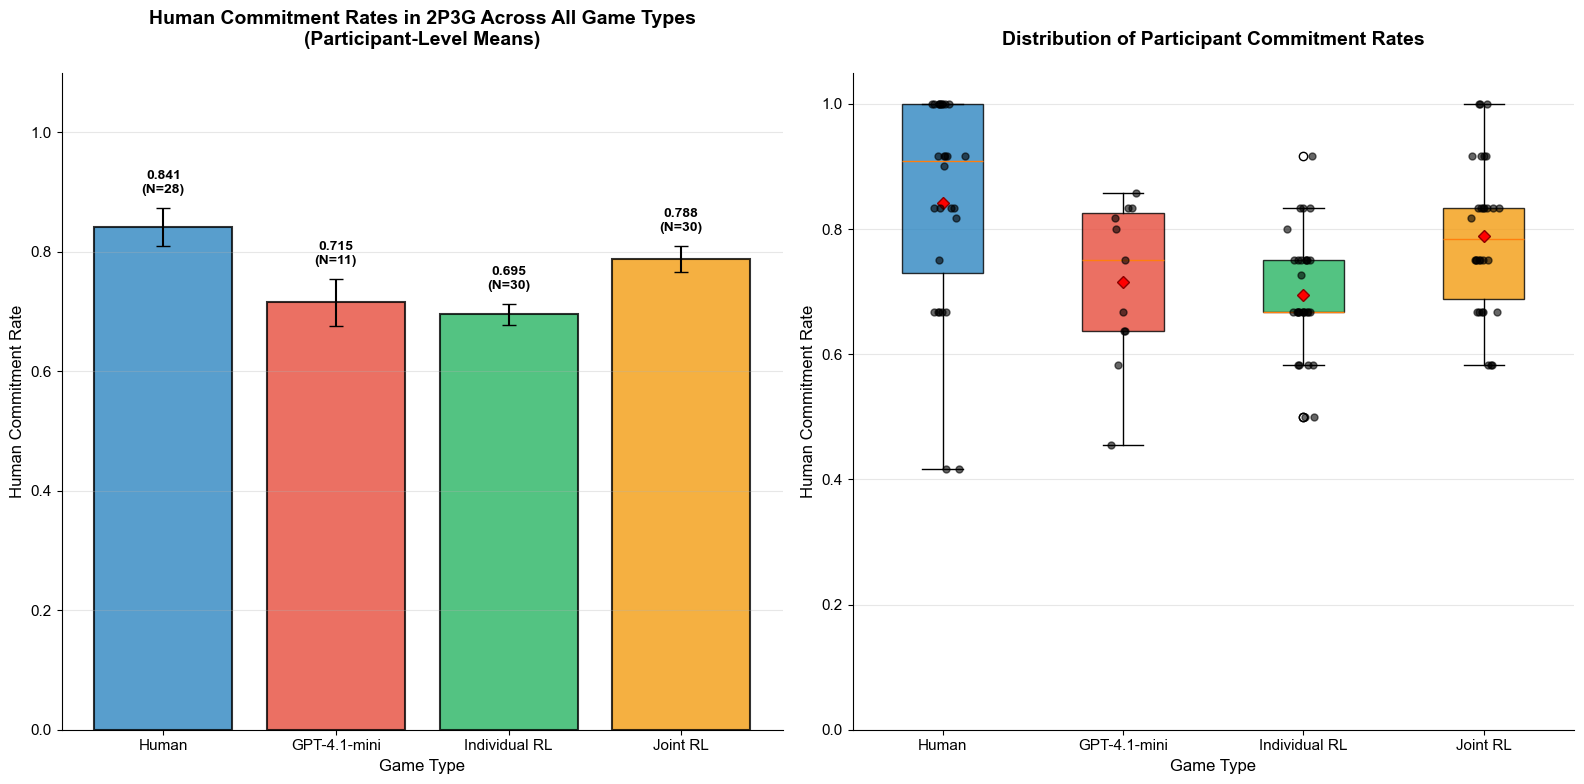


=== DETAILED COMMITMENT STATISTICS (PARTICIPANT-LEVEL) ===

Human:
  Mean commitment rate: 0.841 ± 0.170
  Median commitment rate: 0.908
  Range: 0.417 - 1.000
  N participants: 28

GPT-4.1-mini:
  Mean commitment rate: 0.715 ± 0.129
  Median commitment rate: 0.750
  Range: 0.455 - 0.857
  N participants: 11

Individual RL:
  Mean commitment rate: 0.695 ± 0.097
  Median commitment rate: 0.667
  Range: 0.500 - 0.917
  N participants: 30

Joint RL:
  Mean commitment rate: 0.788 ± 0.121
  Median commitment rate: 0.784
  Range: 0.583 - 1.000
  N participants: 30


In [117]:
# Figure 1: Commitment Rates Across All Four Game Types in 2P3G
if 'merged_commitment_data' in locals() and not merged_commitment_data.empty and 'participant_commitment_rates' in locals() and not participant_commitment_rates.empty:
    print("=== COMMITMENT ANALYSIS VISUALIZATION ===")

    # Use the same game type order and colors as previous analyses
    commitment_game_types = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    commitment_game_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
    commitment_colors = [CONDITION_COLORS[gt] for gt in commitment_game_types]

    # Filter to available game types in participant commitment data
    available_commitment_types = [gt for gt in commitment_game_types if gt in participant_commitment_rates['game_type'].values]
    available_commitment_labels = [commitment_game_labels[commitment_game_types.index(gt)] for gt in available_commitment_types]
    available_commitment_colors = [commitment_colors[commitment_game_types.index(gt)] for gt in available_commitment_types]

    # Create comprehensive visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Bar plot with error bars showing mean commitment rates (participant-level)
    plot_data = []
    plot_errors = []
    plot_ns = []

    for game_type in available_commitment_types:
        participant_data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        if len(participant_data) > 0:
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))  # Standard error
            plot_ns.append(len(participant_data))
        else:
            plot_data.append(0)
            plot_errors.append(0)
            plot_ns.append(0)

    # Create bar plot
    bars = ax1.bar(available_commitment_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_commitment_colors, edgecolor='black', linewidth=1.5)

    # Add value labels and sample sizes on bars
    for i, (bar, mean_val, error_val, n) in enumerate(zip(bars, plot_data, plot_errors, plot_ns)):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Human Commitment Rates in 2P3G Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
    ax1.set_ylabel('Human Commitment Rate')
    ax1.set_xlabel('Game Type')
    ax1.set_ylim(0, 1.1)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Plot 2: Box plot showing distribution of participant commitment rates
    box_data = []
    box_labels = []
    box_colors = []

    for game_type in available_commitment_types:
        participant_data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        if len(participant_data) > 0:
            box_data.append(participant_data.values)
            box_labels.append(available_commitment_labels[available_commitment_types.index(game_type)])
            box_colors.append(available_commitment_colors[available_commitment_types.index(game_type)])

    # Create box plot
    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    # Add strip plot overlay with participant means
    for i, game_type in enumerate(available_commitment_types):
        participant_data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        if len(participant_data) > 0:
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution of Participant Commitment Rates', fontweight='bold', pad=20)
    ax2.set_ylabel('Human Commitment Rate')
    ax2.set_xlabel('Game Type')
    ax2.set_ylim(0, 1.05)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_commitment_analysis_2p3g.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed statistics (participant-level)
    print(f"\n=== DETAILED COMMITMENT STATISTICS (PARTICIPANT-LEVEL) ===")
    for game_type in available_commitment_types:
        participant_data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        label = available_commitment_labels[available_commitment_types.index(game_type)]
        if len(participant_data) > 0:
            print(f"\n{label}:")
            print(f"  Mean commitment rate: {participant_data.mean():.3f} ± {participant_data.std():.3f}")
            print(f"  Median commitment rate: {participant_data.median():.3f}")
            print(f"  Range: {participant_data.min():.3f} - {participant_data.max():.3f}")
            print(f"  N participants: {len(participant_data)}")

else:
    print("Commitment data will be available after running cell 36 (merge commitment data)")

=== COMMITMENT BY DISTANCE CONDITIONS ===
Distance conditions available: ['closer_to_AI', 'closer_to_human', 'equal_to_both', 'no_new_goal']
Participant-distance-game combinations: 439


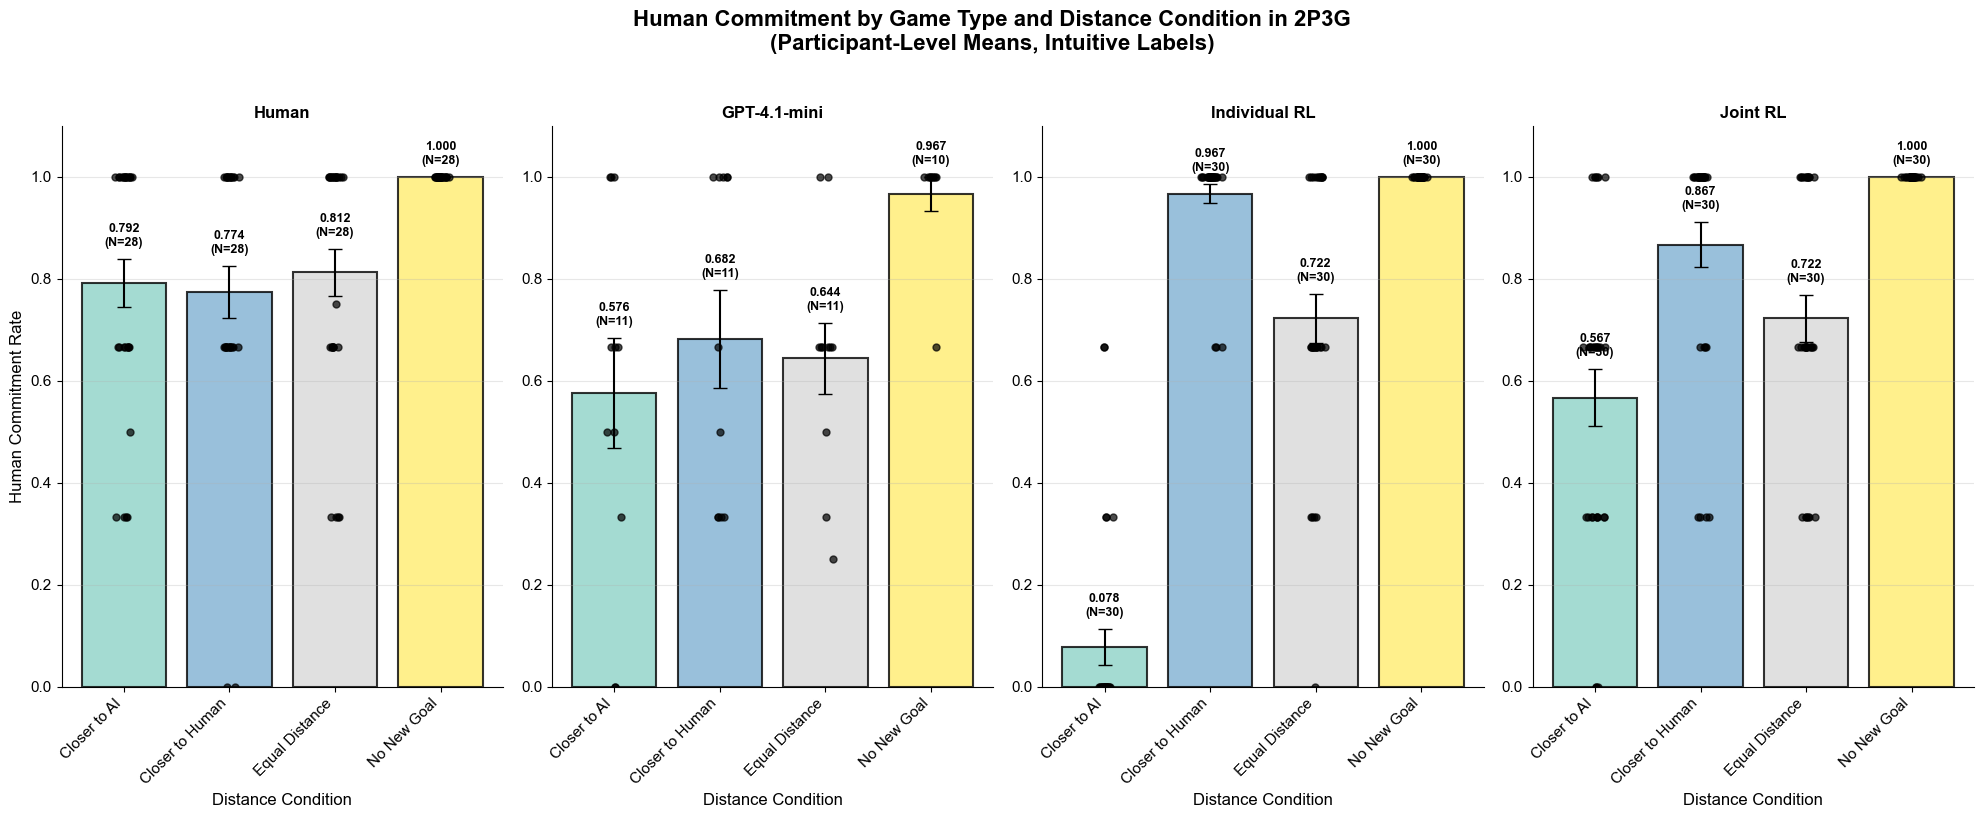


=== COMMITMENT BY GAME TYPE AND DISTANCE CONDITION SUMMARY ===

Human:
  Closer to AI: M = 0.792 ± 0.251, N = 28
  Closer to Human: M = 0.774 ± 0.273, N = 28
  Equal Distance: M = 0.812 ± 0.246, N = 28
  No New Goal: M = 1.000 ± 0.000, N = 28

GPT-4.1-mini:
  Closer to AI: M = 0.576 ± 0.360, N = 11
  Closer to Human: M = 0.682 ± 0.320, N = 11
  Equal Distance: M = 0.644 ± 0.230, N = 11
  No New Goal: M = 0.967 ± 0.105, N = 10

Individual RL:
  Closer to AI: M = 0.078 ± 0.189, N = 30
  Closer to Human: M = 0.967 ± 0.102, N = 30
  Equal Distance: M = 0.722 ± 0.264, N = 30
  No New Goal: M = 1.000 ± 0.000, N = 30

Joint RL:
  Closer to AI: M = 0.567 ± 0.305, N = 30
  Closer to Human: M = 0.867 ± 0.241, N = 30
  Equal Distance: M = 0.722 ± 0.249, N = 30
  No New Goal: M = 1.000 ± 0.000, N = 30

✅ Using human-friendly distance condition labels
✅ closer_to_human = new goal is closer to human player
✅ closer_to_AI = new goal is closer to AI partner


In [118]:
# Figure 2: Commitment by Distance Conditions Across Game Types
if 'merged_commitment_data' in locals() and not merged_commitment_data.empty and 'participant_commitment_rates' in locals() and not participant_commitment_rates.empty:
    print("=== COMMITMENT BY DISTANCE CONDITIONS ===")

    # Check if distanceCondition is available in the merged commitment data
    if 'distanceCondition' in merged_commitment_data.columns:
        # Create participant-level commitment means by distance condition and game type
        participant_distance_commitment = merged_commitment_data.groupby(
            ['participant_id', 'game_type', 'study', 'distanceCondition']
        )['human_commitment'].mean().reset_index()
        participant_distance_commitment['commitment_rate'] = participant_distance_commitment['human_commitment']

        print(f"Distance conditions available: {sorted(merged_commitment_data['distanceCondition'].unique())}")
        print(f"Participant-distance-game combinations: {len(participant_distance_commitment)}")

        # Get unique distance conditions with human-friendly names
        distance_conditions = sorted(participant_distance_commitment['distanceCondition'].unique())
        available_commitment_types = [gt for gt in commitment_game_types if gt in participant_commitment_rates['game_type'].values]
        available_commitment_labels = [commitment_game_labels[commitment_game_types.index(gt)] for gt in available_commitment_types]

        # Create visualization with game types as subplots
        fig, axes = plt.subplots(1, len(available_commitment_types), figsize=(5 * len(available_commitment_types), 8))
        if len(available_commitment_types) == 1:
            axes = [axes]  # Make it iterable for single game type

        # Define colors for distance conditions with human-friendly mapping
        distance_colors = plt.cm.Set3(np.linspace(0, 1, len(distance_conditions)))

        for i, game_type in enumerate(available_commitment_types):
            ax = axes[i]
            game_label = available_commitment_labels[i]

            # Filter data for this game type
            game_data = participant_distance_commitment[
                participant_distance_commitment['game_type'] == game_type
            ]

            if len(game_data) > 0:
                # Prepare data for plotting - distance conditions as bars
                plot_data = []
                plot_errors = []
                plot_ns = []
                plot_labels = []
                plot_colors = []

                for j, distance_condition in enumerate(distance_conditions):
                    distance_game_data = game_data[game_data['distanceCondition'] == distance_condition]['commitment_rate']
                    if len(distance_game_data) > 0:
                        plot_data.append(distance_game_data.mean())
                        plot_errors.append(distance_game_data.std() / np.sqrt(len(distance_game_data)))
                        plot_ns.append(len(distance_game_data))

                        # Create human-friendly label
                        if pd.isna(distance_condition) or distance_condition == 'nan':
                            label = 'No Goal'
                        elif distance_condition == 'no_new_goal':
                            label = 'No New Goal'
                        elif distance_condition == 'closer_to_human':
                            label = 'Closer to Human'
                        elif distance_condition == 'closer_to_AI':
                            label = 'Closer to AI'
                        elif distance_condition == 'equal_to_both':
                            label = 'Equal Distance'
                        elif distance_condition == 'farther_to_human':
                            label = 'Farther from Human'
                        else:
                            label = str(distance_condition)

                        plot_labels.append(label)
                        plot_colors.append(distance_colors[j])

                if plot_data:  # Only plot if we have data
                    # Create bar plot
                    bars = ax.bar(range(len(plot_labels)), plot_data, yerr=plot_errors, capsize=5,
                                  alpha=0.8, color=plot_colors, edgecolor='black', linewidth=1.5)

                    # Set x-axis labels
                    ax.set_xticks(range(len(plot_labels)))
                    ax.set_xticklabels(plot_labels, rotation=45, ha='right')

                    # Add individual participant points with jitter
                    for j, distance_condition in enumerate(distance_conditions):
                        distance_game_data = game_data[game_data['distanceCondition'] == distance_condition]['commitment_rate']
                        if len(distance_game_data) > 0:
                            x_positions = np.random.normal(j, 0.04, size=len(distance_game_data))
                            ax.scatter(x_positions, distance_game_data, color='black', alpha=0.7, s=25, zorder=3)

                    # Add value labels and sample sizes on bars
                    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
                        ax.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=9)

                    ax.set_title(f'{game_label}', fontweight='bold', fontsize=12)
                    ax.set_ylabel('Human Commitment Rate' if i == 0 else '')
                    ax.set_xlabel('Distance Condition')
                    ax.set_ylim(0, 1.1)
                    ax.grid(True, alpha=0.3, axis='y')
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                else:
                    ax.set_title(f'{game_label}\n(No Data)', fontweight='bold')
                    ax.set_visible(False)
            else:
                ax.set_title(f'{game_label}\n(No Data)', fontweight='bold')
                ax.set_visible(False)

        plt.suptitle('Human Commitment by Game Type and Distance Condition in 2P3G\n(Participant-Level Means, Intuitive Labels)',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('merged_commitment_by_distance_condition_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print summary statistics by game type and distance condition
        print(f"\n=== COMMITMENT BY GAME TYPE AND DISTANCE CONDITION SUMMARY ===")
        for game_type in available_commitment_types:
            game_label = available_commitment_labels[available_commitment_types.index(game_type)]
            print(f"\n{game_label}:")
            game_data = participant_distance_commitment[
                participant_distance_commitment['game_type'] == game_type
            ]

            for distance_condition in distance_conditions:
                distance_game_data = game_data[game_data['distanceCondition'] == distance_condition]['commitment_rate']
                if len(distance_game_data) > 0:
                    # Create human-friendly label for summary
                    if pd.isna(distance_condition) or distance_condition == 'nan':
                        label = 'No Goal'
                    elif distance_condition == 'no_new_goal':
                        label = 'No New Goal'
                    elif distance_condition == 'closer_to_human':
                        label = 'Closer to Human'
                    elif distance_condition == 'closer_to_AI':
                        label = 'Closer to AI'
                    elif distance_condition == 'equal_to_both':
                        label = 'Equal Distance'
                    elif distance_condition == 'farther_to_human':
                        label = 'Farther from Human'
                    else:
                        label = str(distance_condition)

                    print(f"  {label}: M = {distance_game_data.mean():.3f} ± {distance_game_data.std():.3f}, N = {len(distance_game_data)}")

        print(f"\n✅ Using human-friendly distance condition labels")
        print(f"✅ closer_to_human = new goal is closer to human player")
        print(f"✅ closer_to_AI = new goal is closer to AI partner")

    else:
        print("❌ distanceCondition column not found in merged commitment data")
        print(f"Available columns: {list(merged_commitment_data.columns)}")

else:
    print("Commitment data will be available after running cell 36 (merge commitment data)")

In [119]:
# Statistical Analysis and Summary of Commitment Results
if 'merged_commitment_data' in locals() and not merged_commitment_data.empty and 'participant_commitment_rates' in locals() and not participant_commitment_rates.empty:
    print("=== STATISTICAL ANALYSIS OF COMMITMENT ACROSS GAME TYPES ===")

    # Define variables needed for statistical analysis
    commitment_game_types = ['human', 'gpt-4.1-mini', 'individual_rl', 'joint_rl']
    commitment_game_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']
    available_commitment_types = [gt for gt in commitment_game_types if gt in participant_commitment_rates['game_type'].values]
    available_commitment_labels = [commitment_game_labels[commitment_game_types.index(gt)] for gt in available_commitment_types]

    # Overall descriptive statistics
    print("\nDescriptive Statistics by Game Type:")
    for game_type in available_commitment_types:
        data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        label = available_commitment_labels[available_commitment_types.index(game_type)]
        if len(data) > 0:
            print(f"{label}: M = {data.mean():.3f}, SD = {data.std():.3f}, N = {len(data)}, Range = [{data.min():.3f}, {data.max():.3f}]")

    # Pairwise comparisons between game types
    print("\n\nPairwise Comparisons (t-tests):")

    commitment_comparison_results = []

    for i, j in combinations(range(len(available_commitment_types)), 2):
        type1, type2 = available_commitment_types[i], available_commitment_types[j]
        label1, label2 = available_commitment_labels[i], available_commitment_labels[j]

        data1 = participant_commitment_rates[participant_commitment_rates['game_type'] == type1]['commitment_rate']
        data2 = participant_commitment_rates[participant_commitment_rates['game_type'] == type2]['commitment_rate']

        if len(data1) >= 3 and len(data2) >= 3:
            # Perform independent t-test
            t_stat, p_value = stats.ttest_ind(data1, data2)

            # Calculate Cohen's d
            pooled_std = np.sqrt(((len(data1) - 1) * data1.std()**2 +
                                 (len(data2) - 1) * data2.std()**2) /
                                (len(data1) + len(data2) - 2))
            cohens_d = (data1.mean() - data2.mean()) / pooled_std

            # Effect size interpretation
            effect_size = "Small" if abs(cohens_d) < 0.5 else "Medium" if abs(cohens_d) < 0.8 else "Large"

            # Significance level
            sig_level = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            print(f"\n{label1} vs {label2}:")
            print(f"  {label1}: {data1.mean():.3f} ± {data1.std():.3f} (N={len(data1)})")
            print(f"  {label2}: {data2.mean():.3f} ± {data2.std():.3f} (N={len(data2)})")
            print(f"  t({len(data1)+len(data2)-2}) = {t_stat:.3f}, p = {p_value:.3f}, d = {cohens_d:.3f} ({effect_size})")
            print(f"  Significance: {sig_level}")

            commitment_comparison_results.append({
                'Comparison': f'{label1} vs {label2}',
                'Mean_Diff': data1.mean() - data2.mean(),
                't_stat': t_stat,
                'p_value': p_value,
                'cohens_d': cohens_d,
                'effect_size': effect_size,
                'significance': sig_level
            })
        else:
            print(f"\n{label1} vs {label2}: Insufficient data for comparison")

    # Test each condition against chance level (0.5)
    print("\n\nTesting Against Chance Level (0.5):")
    for i, game_type in enumerate(available_commitment_types):
        data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        label = available_commitment_labels[i]

        if len(data) >= 3:
            t_stat, p_value = stats.ttest_1samp(data, 0.5)
            sig_level = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"{label}: M = {data.mean():.3f}, t({len(data)-1}) = {t_stat:.3f}, p = {p_value:.3f} {sig_level}")
        else:
            print(f"{label}: Insufficient data (N = {len(data)})")

    # Create comprehensive summary table
    commitment_summary_data = []

    for i, game_type in enumerate(available_commitment_types):
        data = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['commitment_rate']
        label = available_commitment_labels[i]

        if len(data) > 0:
            # Calculate 95% confidence interval
            ci = stats.t.interval(0.95, len(data)-1, loc=data.mean(), scale=stats.sem(data))

            # Determine which study this comes from
            study = participant_commitment_rates[participant_commitment_rates['game_type'] == game_type]['study'].iloc[0]

            commitment_summary_data.append({
                'Game_Type': label,
                'Study': study,
                'N': len(data),
                'Mean': f"{data.mean():.3f}",
                'SD': f"{data.std():.3f}",
                'SE': f"{stats.sem(data):.3f}",
                'CI_95_Lower': f"{ci[0]:.3f}",
                'CI_95_Upper': f"{ci[1]:.3f}",
                'Min': f"{data.min():.3f}",
                'Max': f"{data.max():.3f}"
            })

    commitment_summary_table = pd.DataFrame(commitment_summary_data)

    print("\n=== COMPREHENSIVE COMMITMENT SUMMARY TABLE ===")
    print(commitment_summary_table.to_string(index=False))

    # Save results
    commitment_summary_table.to_csv('merged_commitment_summary_2p3g.csv', index=False)
    participant_commitment_rates.to_csv('merged_commitment_participant_data_2p3g.csv', index=False)

    if commitment_comparison_results:
        commitment_comparison_df = pd.DataFrame(commitment_comparison_results)
        commitment_comparison_df.to_csv('merged_commitment_pairwise_comparisons_2p3g.csv', index=False)
        print("\n✓ Pairwise comparison results saved to merged_commitment_pairwise_comparisons_2p3g.csv")

    print("\n=== COMMITMENT ANALYSIS FILES SAVED ===")
    print("✓ merged_commitment_summary_2p3g.csv - Summary statistics table")
    print("✓ merged_commitment_participant_data_2p3g.csv - Participant-level commitment rates")
    print("✓ merged_commitment_analysis_2p3g.png - Main commitment visualization")
    print("✓ merged_commitment_by_distance_condition_2p3g.png - Commitment by distance conditions")

    print(f"\n=== FINAL COMMITMENT SUMMARY ===")
    print(f"Total participants analyzed: {len(participant_commitment_rates)}")
    print(f"Studies included: {', '.join(participant_commitment_rates['study'].unique())}")
    print(f"Game types compared: {', '.join(available_commitment_labels)}")
    print("\n🎯 Commitment analysis complete! 🎉")
    print("✅ Using correct player indexing:")
    print("   - Human-Human-GPT: Based on humanPlayerIndex (0 or 1)")
    print("   - Human-RL: Human is always player 1 (index 0)")

else:
    print("Commitment data will be available after running cells 35-36 (load and merge commitment data)")

=== STATISTICAL ANALYSIS OF COMMITMENT ACROSS GAME TYPES ===

Descriptive Statistics by Game Type:
Human: M = 0.841, SD = 0.170, N = 28, Range = [0.417, 1.000]
GPT-4.1-mini: M = 0.715, SD = 0.129, N = 11, Range = [0.455, 0.857]
Individual RL: M = 0.695, SD = 0.097, N = 30, Range = [0.500, 0.917]
Joint RL: M = 0.788, SD = 0.121, N = 30, Range = [0.583, 1.000]


Pairwise Comparisons (t-tests):

Human vs GPT-4.1-mini:
  Human: 0.841 ± 0.170 (N=28)
  GPT-4.1-mini: 0.715 ± 0.129 (N=11)
  t(37) = 2.208, p = 0.034, d = 0.786 (Medium)
  Significance: *

Human vs Individual RL:
  Human: 0.841 ± 0.170 (N=28)
  Individual RL: 0.695 ± 0.097 (N=30)
  t(56) = 4.041, p = 0.000, d = 1.062 (Large)
  Significance: ***

Human vs Joint RL:
  Human: 0.841 ± 0.170 (N=28)
  Joint RL: 0.788 ± 0.121 (N=30)
  t(56) = 1.367, p = 0.177, d = 0.359 (Small)
  Significance: ns

GPT-4.1-mini vs Individual RL:
  GPT-4.1-mini: 0.715 ± 0.129 (N=11)
  Individual RL: 0.695 ± 0.097 (N=30)
  t(39) = 0.534, p = 0.596, d = 0.1

## Step 12: AI Commitment Analysis by Game Type and Distance Conditions in 2P3G

Analysis of AI commitment patterns across the three human-AI game types (GPT-4.1-mini, Individual RL, Joint RL) and distance conditions in 2P3G games. AI commitment is calculated as whether the AI's final reached goal matches the first detected shared goal, mirroring the human commitment definition.


In [120]:
# AI Commitment Analysis for 2P3G Games
print("=== AI COMMITMENT ANALYSIS: 2P3G ACROSS HUMAN-AI GAME TYPES ===")

def calculate_ai_commitment_2p3g(row, study_type):
    """Calculate AI commitment in 2P3G as whether the AI's final reached goal equals the first detected shared goal."""

    # Shared goal that defines commitment for the trial
    shared_goal = row.get('firstDetectedSharedGoal')
    if pd.isna(shared_goal):
        return np.nan

    # Determine AI player's final reached goal based on study type
    if study_type == 'Human-RL':
        # Human is player 1, AI is player 2
        ai_final_goal = row.get('player2FinalReachedGoal')
    elif study_type == 'Human-Human-GPT':
        # Identify AI index from humanPlayerIndex
        human_index = row.get('humanPlayerIndex')
        if pd.isna(human_index):
            human_index = 0
        ai_index = 1 if human_index == 0 else 0
        ai_final_goal = row.get('player1FinalReachedGoal') if ai_index == 0 else row.get('player2FinalReachedGoal')
    else:
        return np.nan

    if pd.isna(ai_final_goal):
        return np.nan

    # Compare as integers for robustness
    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if ai_final_goal == shared_goal else 0
    except (ValueError, TypeError):
        return np.nan

# Filter to only human-AI game types for AI commitment analysis
human_ai_types = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']

if 'merged_commitment_data' in locals() and not merged_commitment_data.empty:
    # Filter to human-AI game types only
    ai_commitment_data = merged_commitment_data[merged_commitment_data['game_type'].isin(human_ai_types)].copy()

    print(f"AI commitment data: {len(ai_commitment_data)} trials from human-AI game types")
    print(f"Game types: {sorted(ai_commitment_data['game_type'].unique())}")

    # Calculate AI commitment for each trial
    ai_commitment_data['ai_commitment'] = ai_commitment_data.apply(
        lambda row: calculate_ai_commitment_2p3g(row, 'Human-RL' if row['game_type'] in ['individual_rl', 'joint_rl'] else 'Human-Human-GPT'),
        axis=1
    )

    # Remove trials where AI commitment couldn't be calculated
    ai_commitment_data = ai_commitment_data.dropna(subset=['ai_commitment'])

    print(f"AI commitment data after filtering: {len(ai_commitment_data)} trials")

    # Calculate AI commitment rates by game type and distance condition
    ai_commitment_by_condition = ai_commitment_data.groupby(['game_type', 'distanceCondition']).agg({
        'ai_commitment': ['count', 'mean', 'std']
    }).round(3)

    ai_commitment_by_condition.columns = ['N', 'AI_Commitment_Rate', 'SD']
    ai_commitment_by_condition = ai_commitment_by_condition.reset_index()

    print(f"\n=== AI COMMITMENT BY GAME TYPE AND DISTANCE CONDITION ===")
    print(ai_commitment_by_condition.to_string(index=False))

    # Calculate participant-level AI commitment rates
    ai_participant_commitment = ai_commitment_data.groupby(['participant_id', 'game_type'])['ai_commitment'].mean().reset_index()
    ai_participant_commitment.columns = ['participant_id', 'game_type', 'ai_commitment_rate']

    # Add distance condition analysis
    distance_conditions = ['closer_to_human', 'closer_to_AI', 'equal_to_both', 'no_new_goal']
    key_ai_commitment_data = ai_commitment_data[ai_commitment_data['distanceCondition'].isin(distance_conditions)]

    if not key_ai_commitment_data.empty:
        print(f"\n=== AI COMMITMENT BY DISTANCE CONDITION ANALYSIS ===")
        key_ai_by_distance = key_ai_commitment_data.groupby(['game_type', 'distanceCondition']).agg({
            'ai_commitment': ['count', 'mean', 'std']
        }).round(3)

        key_ai_by_distance.columns = ['N', 'AI_Commitment_Rate', 'SD']
        key_ai_by_distance = key_ai_by_distance.reset_index()

        print(f"Key Distance Conditions AI Commitment Analysis (N={len(key_ai_commitment_data)} trials):")
        print(key_ai_by_distance.to_string(index=False))

    print(f"\n✅ AI commitment analysis ready with {len(ai_commitment_data)} trials across {len(ai_participant_commitment)} participant-game type combinations")

else:
    print("No commitment data available for AI commitment analysis")


=== AI COMMITMENT ANALYSIS: 2P3G ACROSS HUMAN-AI GAME TYPES ===
AI commitment data: 837 trials from human-AI game types
Game types: ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
AI commitment data after filtering: 837 trials

=== AI COMMITMENT BY GAME TYPE AND DISTANCE CONDITION ===
    game_type distanceCondition  N  AI_Commitment_Rate    SD
 gpt-4.1-mini      closer_to_AI 28               0.643 0.488
 gpt-4.1-mini   closer_to_human 32               0.625 0.492
 gpt-4.1-mini     equal_to_both 33               0.636 0.489
 gpt-4.1-mini       no_new_goal 28               0.857 0.356
individual_rl      closer_to_AI 88               0.034 0.183
individual_rl   closer_to_human 90               1.000 0.000
individual_rl     equal_to_both 90               0.711 0.456
individual_rl       no_new_goal 89               1.000 0.000
     joint_rl      closer_to_AI 89               0.551 0.500
     joint_rl   closer_to_human 90               0.867 0.342
     joint_rl     equal_to_both 90           

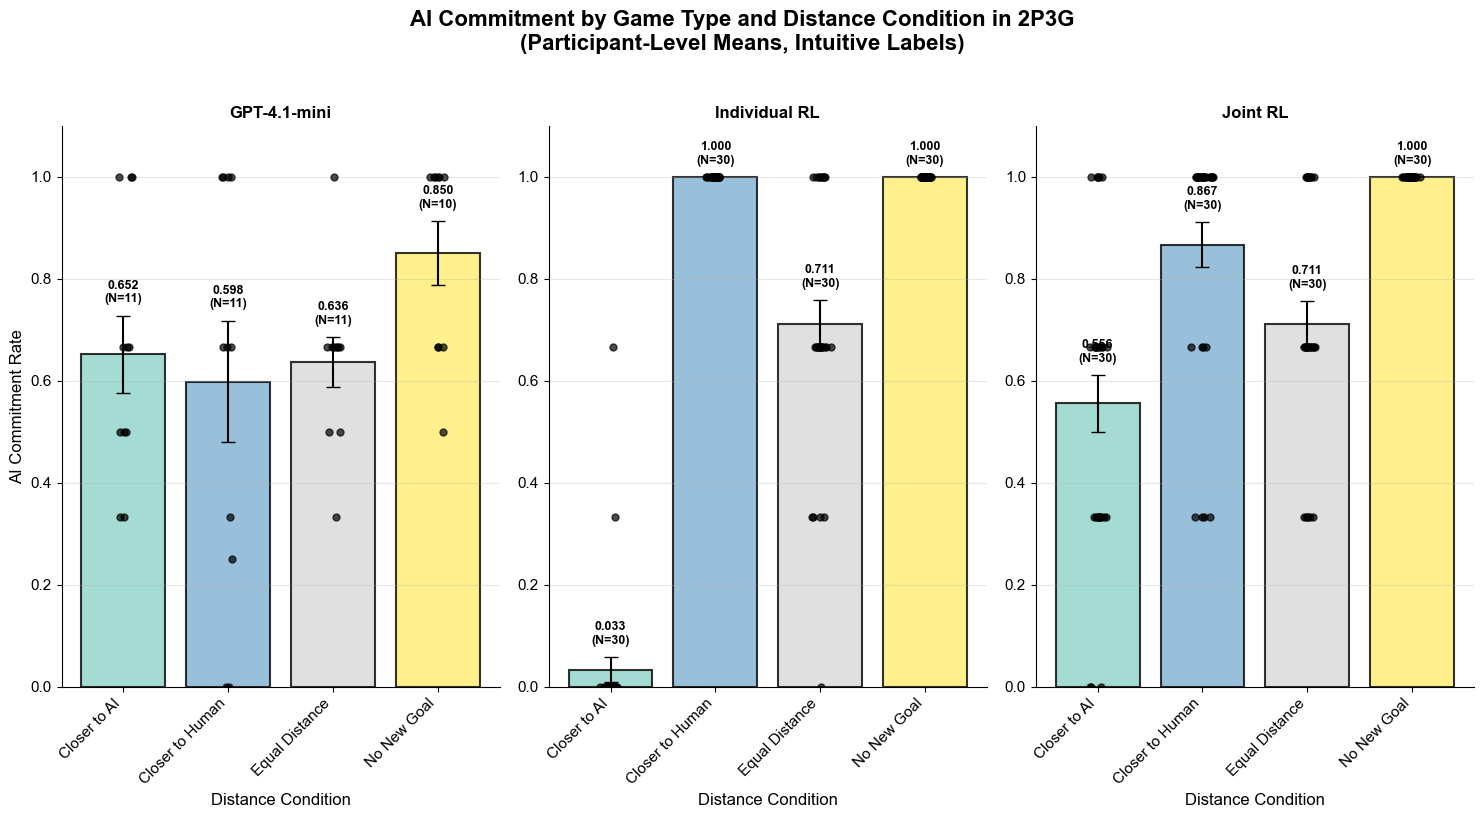

In [125]:
if 'ai_commitment_data' in locals() and not ai_commitment_data.empty:
    ai_participant_distance_commitment = ai_commitment_data.groupby([
        'participant_id', 'game_type', 'distanceCondition'
    ])['ai_commitment'].mean().reset_index()
    ai_participant_distance_commitment['ai_commitment_rate'] = ai_participant_distance_commitment['ai_commitment']

    ai_game_types = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
    ai_game_labels = ['GPT-4.1-mini', 'Individual RL', 'Joint RL']
    available_ai_types = [gt for gt in ai_game_types if gt in ai_participant_distance_commitment['game_type'].values]

    distance_order = ['closer_to_AI', 'closer_to_human', 'equal_to_both', 'no_new_goal']
    unique_conditions = list(ai_participant_distance_commitment['distanceCondition'].dropna().unique())
    distance_conditions = [d for d in distance_order if d in unique_conditions]
    distance_colors = plt.cm.Set3(np.linspace(0, 1, len(distance_conditions)))

    fig, axes = plt.subplots(1, len(available_ai_types), figsize=(5 * len(available_ai_types), 8))
    if len(available_ai_types) == 1:
        axes = [axes]

    for i, game_type in enumerate(available_ai_types):
        ax = axes[i]
        game_label = ai_game_labels[ai_game_types.index(game_type)]
        game_data = ai_participant_distance_commitment[ai_participant_distance_commitment['game_type'] == game_type]

        plot_data, plot_errors, plot_labels, plot_ns, plot_colors = [], [], [], [], []
        for j, distance_condition in enumerate(distance_conditions):
            condition_data = game_data[game_data['distanceCondition'] == distance_condition]['ai_commitment_rate']
            if len(condition_data) > 0:
                plot_data.append(condition_data.mean())
                plot_errors.append(condition_data.std() / np.sqrt(len(condition_data)))
                plot_ns.append(len(condition_data))
                if pd.isna(distance_condition) or distance_condition == 'nan':
                    label = 'No Goal'
                elif distance_condition == 'no_new_goal':
                    label = 'No New Goal'
                elif distance_condition == 'closer_to_human':
                    label = 'Closer to Human'
                elif distance_condition == 'closer_to_AI':
                    label = 'Closer to AI'
                elif distance_condition == 'equal_to_both':
                    label = 'Equal Distance'
                elif distance_condition == 'farther_to_human':
                    label = 'Farther from Human'
                else:
                    label = str(distance_condition)
                plot_labels.append(label)
                plot_colors.append(distance_colors[j])

        if plot_data:
            bars = ax.bar(range(len(plot_labels)), plot_data, yerr=plot_errors, capsize=5,
                          alpha=0.8, color=plot_colors, edgecolor='black', linewidth=1.5)
            ax.set_xticks(range(len(plot_labels)))
            ax.set_xticklabels(plot_labels, rotation=45, ha='right')
            for j, distance_condition in enumerate(distance_conditions):
                condition_data = game_data[game_data['distanceCondition'] == distance_condition]['ai_commitment_rate']
                if len(condition_data) > 0:
                    x_positions = np.random.normal(j, 0.04, size=len(condition_data))
                    ax.scatter(x_positions, condition_data, color='black', alpha=0.7, s=25, zorder=3)
            for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
                ax.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                        f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=9)
            ax.set_title(f'{game_label}', fontweight='bold', fontsize=12)
            ax.set_ylabel('AI Commitment Rate' if i == 0 else '')
            ax.set_xlabel('Distance Condition')
            ax.set_ylim(0, 1.1)
            ax.grid(True, alpha=0.3, axis='y')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        else:
            ax.set_title(f'{game_label}\n(No Data)', fontweight='bold')
            ax.set_visible(False)

    plt.suptitle('AI Commitment by Game Type and Distance Condition in 2P3G\n(Participant-Level Means, Intuitive Labels)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('merged_ai_commitment_by_distance_condition_2p3g.png', dpi=300, bbox_inches='tight')
    plt.show()


In [122]:
# Statistical Analysis of AI Commitment Across Game Types and Distance Conditions
if 'ai_commitment_data' in locals() and not ai_commitment_data.empty and 'ai_participant_commitment' in locals() and not ai_participant_commitment.empty:
    print("=== STATISTICAL ANALYSIS OF AI COMMITMENT ACROSS GAME TYPES ===")

    # Filter to available AI game types
    available_ai_types = [gt for gt in ['gpt-4.1-mini', 'individual_rl', 'joint_rl'] if gt in ai_participant_commitment['game_type'].values]

    # Descriptive statistics by game type
    print("\\nDescriptive Statistics by AI Game Type:")
    ai_stats_summary = []

    for game_type in available_ai_types:
        participant_data = ai_participant_commitment[ai_participant_commitment['game_type'] == game_type]['ai_commitment_rate']
        if len(participant_data) > 0:
            mean_val = participant_data.mean()
            std_val = participant_data.std()
            n_val = len(participant_data)
            min_val = participant_data.min()
            max_val = participant_data.max()

            game_label = {'gpt-4.1-mini': 'GPT-4.1-mini', 'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}[game_type]
            print(f"{game_label}: M = {mean_val:.3f}, SD = {std_val:.3f}, N = {n_val}, Range = [{min_val:.3f}, {max_val:.3f}]")

            ai_stats_summary.append({
                'Game_Type': game_label,
                'Study': 'Human-Human-GPT' if game_type == 'gpt-4.1-mini' else 'Human-RL',
                'N': n_val,
                'Mean': mean_val,
                'SD': std_val,
                'SE': std_val / np.sqrt(n_val),
                'CI_95_Lower': mean_val - 1.96 * (std_val / np.sqrt(n_val)),
                'CI_95_Upper': mean_val + 1.96 * (std_val / np.sqrt(n_val)),
                'Min': min_val,
                'Max': max_val
            })

    # Pairwise comparisons between AI game types
    if len(available_ai_types) > 1:
        print("\\n\\nPairwise Comparisons (t-tests):")

        ai_pairwise_results = []

        for i in range(len(available_ai_types)):
            for j in range(i+1, len(available_ai_types)):
                type1, type2 = available_ai_types[i], available_ai_types[j]
                label1 = {'gpt-4.1-mini': 'GPT-4.1-mini', 'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}[type1]
                label2 = {'gpt-4.1-mini': 'GPT-4.1-mini', 'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}[type2]

                data1 = ai_participant_commitment[ai_participant_commitment['game_type'] == type1]['ai_commitment_rate']
                data2 = ai_participant_commitment[ai_participant_commitment['game_type'] == type2]['ai_commitment_rate']

                if len(data1) > 1 and len(data2) > 1:
                    # Perform independent t-test
                    t_stat, p_val = stats.ttest_ind(data1, data2)

                    # Calculate effect size (Cohen's d)
                    pooled_std = np.sqrt(((len(data1)-1)*data1.var() + (len(data2)-1)*data2.var()) / (len(data1)+len(data2)-2))
                    cohens_d = (data1.mean() - data2.mean()) / pooled_std

                    # Effect size interpretation
                    if abs(cohens_d) < 0.2:
                        effect_size = "Small"
                    elif abs(cohens_d) < 0.8:
                        effect_size = "Medium"
                    else:
                        effect_size = "Large"

                    # Significance level
                    if p_val < 0.001:
                        sig = "***"
                    elif p_val < 0.01:
                        sig = "**"
                    elif p_val < 0.05:
                        sig = "*"
                    else:
                        sig = "ns"

                    print(f"\\n{label1} vs {label2}:")
                    print(f"  {label1}: {data1.mean():.3f} ± {data1.std():.3f} (N={len(data1)})")
                    print(f"  {label2}: {data2.mean():.3f} ± {data2.std():.3f} (N={len(data2)})")
                    print(f"  t({len(data1)+len(data2)-2}) = {t_stat:.3f}, p = {p_val:.3f}, d = {cohens_d:.3f} ({effect_size})")
                    print(f"  Significance: {sig}")

                    ai_pairwise_results.append({
                        'Comparison': f"{label1} vs {label2}",
                        't_statistic': t_stat,
                        'p_value': p_val,
                        'cohens_d': cohens_d,
                        'effect_size': effect_size,
                        'significance': sig
                    })

    # Test against chance level (0.5) for AI commitment
    print("\\n\\nTesting Against Chance Level (0.5):")
    ai_chance_results = []

    for game_type in available_ai_types:
        participant_data = ai_participant_commitment[ai_participant_commitment['game_type'] == game_type]['ai_commitment_rate']
        if len(participant_data) > 1:
            game_label = {'gpt-4.1-mini': 'GPT-4.1-mini', 'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}[game_type]

            # One-sample t-test against 0.5
            t_stat, p_val = stats.ttest_1samp(participant_data, 0.5)

            if p_val < 0.001:
                sig = "***"
            elif p_val < 0.01:
                sig = "**"
            elif p_val < 0.05:
                sig = "*"
            else:
                sig = "ns"

            print(f"{game_label}: M = {participant_data.mean():.3f}, t({len(participant_data)-1}) = {t_stat:.3f}, p = {p_val:.3f} {sig}")

            ai_chance_results.append({
                'Game_Type': game_label,
                'Mean': participant_data.mean(),
                't_statistic': t_stat,
                'df': len(participant_data) - 1,
                'p_value': p_val,
                'significance': sig
            })

    # Analysis by Distance Condition
    if 'key_ai_commitment_data' in locals() and not key_ai_commitment_data.empty:
        print("\\n\\n=== AI COMMITMENT BY DISTANCE CONDITION ANALYSIS ===")

        distance_conditions = ['closer_to_human', 'closer_to_AI', 'equal_to_both', 'no_new_goal']
        available_distances = [d for d in distance_conditions if d in key_ai_commitment_data['distanceCondition'].values]

        for game_type in available_ai_types:
            game_label = {'gpt-4.1-mini': 'GPT-4.1-mini', 'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}[game_type]
            game_data = key_ai_commitment_data[key_ai_commitment_data['game_type'] == game_type]

            if not game_data.empty:
                print(f"\\n{game_label} AI Commitment by Distance Condition:")

                for condition in available_distances:
                    condition_data = game_data[game_data['distanceCondition'] == condition]['ai_commitment']
                    if len(condition_data) > 0:
                        condition_label = condition.replace('_', ' ').title()
                        print(f"  {condition_label}: M = {condition_data.mean():.3f}, SD = {condition_data.std():.3f}, N = {len(condition_data)}")

    # Summary table
    print("\\n\\n=== COMPREHENSIVE AI COMMITMENT SUMMARY TABLE ===")
    if ai_stats_summary:
        ai_summary_df = pd.DataFrame(ai_stats_summary)
        ai_summary_df = ai_summary_df.round(3)
        print(ai_summary_df.to_string(index=False))

        # Save summary tables
        ai_summary_df.to_csv('merged_ai_commitment_summary_2p3g.csv', index=False)

        if 'ai_pairwise_results' in locals():
            pd.DataFrame(ai_pairwise_results).to_csv('merged_ai_commitment_pairwise_comparisons_2p3g.csv', index=False)

        if 'ai_chance_results' in locals():
            pd.DataFrame(ai_chance_results).to_csv('merged_ai_commitment_chance_tests_2p3g.csv', index=False)

    # Save participant-level data
    ai_participant_commitment.to_csv('merged_ai_commitment_participant_data_2p3g.csv', index=False)

    print("\\n\\n=== AI COMMITMENT ANALYSIS FILES SAVED ===")
    print("✓ merged_ai_commitment_analysis_2p3g.png - Main AI commitment visualization")
    print("✓ merged_ai_commitment_summary_2p3g.csv - Descriptive statistics by game type")
    print("✓ merged_ai_commitment_participant_data_2p3g.csv - Participant-level AI commitment rates")
    print("✓ merged_ai_commitment_pairwise_comparisons_2p3g.csv - Pairwise comparison results")
    print("✓ merged_ai_commitment_chance_tests_2p3g.csv - Tests against chance level")

    print("\\n🎯 AI commitment analysis complete! 🎉")
    print("✅ Key findings:")
    print("   - AI commitment defined as AI's final reached goal matching the shared goal")
    print("   - Analysis covers GPT-4.1-mini, Individual RL, and Joint RL game types")
    print("   - Includes distance condition analysis and statistical comparisons")

else:
    print("AI commitment data will be available after running the AI commitment analysis cells")


=== STATISTICAL ANALYSIS OF AI COMMITMENT ACROSS GAME TYPES ===
\nDescriptive Statistics by AI Game Type:
GPT-4.1-mini: M = 0.679, SD = 0.140, N = 11, Range = [0.455, 0.833]
Individual RL: M = 0.690, SD = 0.077, N = 30, Range = [0.500, 0.833]
Joint RL: M = 0.783, SD = 0.119, N = 30, Range = [0.583, 1.000]
\n\nPairwise Comparisons (t-tests):
\nGPT-4.1-mini vs Individual RL:
  GPT-4.1-mini: 0.679 ± 0.140 (N=11)
  Individual RL: 0.690 ± 0.077 (N=30)
  t(39) = -0.325, p = 0.747, d = -0.114 (Small)
  Significance: ns
\nGPT-4.1-mini vs Joint RL:
  GPT-4.1-mini: 0.679 ± 0.140 (N=11)
  Joint RL: 0.783 ± 0.119 (N=30)
  t(39) = -2.370, p = 0.023, d = -0.835 (Large)
  Significance: *
\nIndividual RL vs Joint RL:
  Individual RL: 0.690 ± 0.077 (N=30)
  Joint RL: 0.783 ± 0.119 (N=30)
  t(58) = -3.597, p = 0.001, d = -0.929 (Large)
  Significance: ***
\n\nTesting Against Chance Level (0.5):
GPT-4.1-mini: M = 0.679, t(10) = 4.227, p = 0.002 **
Individual RL: M = 0.690, t(29) = 13.496, p = 0.000 ***
J

In [ ]:
# First Intention Step Analysis: Across Game Types with Human vs AI Hue
# Attempts to use intention step columns if available; otherwise falls back to goal reached step columns.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pick_first_intention_columns(df, study):
    # Candidate columns for human and AI first intention steps
    candidates_human = ['firstIntentionStepHuman', 'player1FirstIntentionStep', 'player1GoalReachedStep']
    candidates_ai = ['firstIntentionStepAI', 'player2FirstIntentionStep', 'player2GoalReachedStep']
    # In Human-Human-GPT human could be player1 or player2; AI is the other
    if study == 'Human-Human-GPT' and 'humanPlayerIndex' in df.columns:
        # Create columns mapping by index when both player1/2 versions are present
        p1_cols = {'human': ['player1FirstIntentionStep', 'player1GoalReachedStep'],
                   'ai':    ['player2FirstIntentionStep', 'player2GoalReachedStep']}
        p2_cols = {'human': ['player2FirstIntentionStep', 'player2GoalReachedStep'],
                   'ai':    ['player1FirstIntentionStep', 'player1GoalReachedStep']}
        def resolve_row(row):
            mapping = p1_cols if row.get('humanPlayerIndex', 0) == 0 else p2_cols
            def pick(series_names):
                for c in series_names:
                    if c in df.columns and pd.notna(row.get(c)):
                        return row.get(c)
                return np.nan
            return pd.Series({
                'first_intention_step_human': pick(mapping['human']),
                'first_intention_step_ai': pick(mapping['ai'])
            })
        out = df.apply(resolve_row, axis=1)
        return out['first_intention_step_human'], out['first_intention_step_ai']
    else:
        def pick_col(cols):
            for c in cols:
                if c in df.columns:
                    return c
            return None
        return df.get(pick_col(candidates_human), np.nan), df.get(pick_col(candidates_ai), np.nan)

def extract_participant(file_id):
    try:
        parts = str(file_id).split('_')
        return parts[2] if len(parts) >= 3 else str(file_id)
    except Exception:
        return str(file_id)

plot_df = []
# Human-RL combined commitment trials
if 'rl_combined_commitment' in locals() and not rl_combined_commitment.empty:
    df = rl_combined_commitment.copy()
    human_steps, ai_steps = pick_first_intention_columns(df, 'Human-RL')
    tmp = pd.DataFrame({
        'participant_id': df['file_id'].apply(extract_participant),
        'game_type': df.get('game_type', 'individual_rl'),
        'human_first_intention_step': pd.to_numeric(human_steps, errors='coerce'),
        'ai_first_intention_step': pd.to_numeric(ai_steps, errors='coerce')
    })
    plot_df.append(tmp)
# Human-Human-GPT combined commitment trials
if 'hh_gpt_combined_commitment' in locals() and not hh_gpt_combined_commitment.empty:
    df = hh_gpt_combined_commitment.copy()
    human_steps, ai_steps = pick_first_intention_columns(df, 'Human-Human-GPT')
    tmp = pd.DataFrame({
        'participant_id': df['file_id'].apply(extract_participant),
        'game_type': df.get('game_type', 'gpt-4.1-mini'),
        'human_first_intention_step': pd.to_numeric(human_steps, errors='coerce'),
        'ai_first_intention_step': pd.to_numeric(ai_steps, errors='coerce')
    })
    plot_df.append(tmp)

if plot_df:
    plot_df = pd.concat(plot_df, ignore_index=True)
    # Keep human-AI game types
    plot_df = plot_df[plot_df['game_type'].isin(['gpt-4.1-mini', 'individual_rl', 'joint_rl'])]

    # Melt to long format with agent hue
    long_df = plot_df.melt(id_vars=['participant_id', 'game_type'],
                          value_vars=['human_first_intention_step', 'ai_first_intention_step'],
                          var_name='agent', value_name='first_intention_step')
    long_df['agent'] = long_df['agent'].map({'human_first_intention_step': 'Human', 'ai_first_intention_step': 'AI'})
    long_df = long_df.dropna(subset=['first_intention_step'])

    # Participant-level means
    participant_means = long_df.groupby(['participant_id', 'game_type', 'agent'])['first_intention_step'].mean().reset_index()

    # Aggregate for plotting
    summary = participant_means.groupby(['game_type', 'agent'])['first_intention_step'].agg(['mean', 'std', 'count']).reset_index()
    summary['se'] = summary['std'] / np.sqrt(summary['count'])

    # Plot
    order = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
    labels = {'gpt-4.1-mini': 'GPT-4.1-mini', 'individual_rl': 'Individual RL', 'joint_rl': 'Joint RL'}
    agents = ['Human', 'AI']
    colors = {'Human': '#4C78A8', 'AI': '#F58518'}

    x = np.arange(len(order))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, agent in enumerate(agents):
        vals = []
        errs = []
        ns = []
        for gt in order:
            row = summary[(summary['game_type'] == gt) & (summary['agent'] == agent)]
            if not row.empty:
                vals.append(row['mean'].values[0])
                errs.append(row['se'].values[0])
                ns.append(int(row['count'].values[0]))
            else:
                vals.append(np.nan)
                errs.append(0)
                ns.append(0)
        bars = ax.bar(x + (i-0.5)*width, vals, width, yerr=errs, capsize=5, label=agent,
                      color=colors[agent], alpha=0.85, edgecolor='black')
        for bar, mean_val, se_val, n in zip(bars, vals, errs, ns):
            if not np.isnan(mean_val):
                ax.text(bar.get_x() + bar.get_width()/2., mean_val + se_val + 0.05,
                        f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels([labels[g] for g in order])
    ax.set_ylabel('First Intention Step (mean per participant)')
    ax.set_title('First Intention Step Across Game Types (Human vs AI)')
    ax.legend(frameon=False)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.savefig('merged_first_intention_step_by_agent_2p3g.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('✓ saved figure: merged_first_intention_step_by_agent_2p3g.png')
else:
    print('First intention step inputs not available. Ensure commitment data cells are executed.')
